In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
pd.set_option('display.max_columns', None)

## Carregando 

In [44]:
df_regioes = pd.read_csv('bases_analises/df_regioes.csv')

In [45]:
df_regioes = df_regioes.drop(columns = ['pib_ind_pc', 'razao_pib_renda', 'CD_MUN'])

In [46]:
df_regioes

ano  cod_ibge  emprego_formal  emp_c_sal  massa_rendimentos_num  \
0     2018   3500105           10445       9793            21389288.64   
1     2018   3500204             854        828             1628663.10   
2     2018   3500303            6984       6791            16726576.00   
3     2018   3500402             983        957             2018178.53   
4     2018   3500501            4605       4476             9361612.67   
...    ...       ...             ...        ...                    ...   
1930  2020   3557006           19192      16953            51887106.26   
1931  2020   3557105           26761      24148            58632076.82   
1932  2020   3557154             579        554             1423809.76   
1933  2020   3557204            1772       1675             5109110.53   
1934  2020   3557303            1845       1734             4529398.91   

      qtd_formal_Administração_Pública  qtd_formal_Agropecuária  \
0                                  996                      692   
1                                  309                      318   
2                                  855                     1343   
3                                  281                      206   
4                                  861                       55   
...                                ...                      ...   
1930                              2431                       47   
1931                              2427                      204   
1932                               245                      195   
1933                               447                      143   
1934                               482                      360   

      qtd_formal_Alojamento_e_Alimentação  qtd_formal_Artes_e_Cultura  \
0                                     275                          20   
1                                       2                           9   
2                                     133                          27   
3                                      29                           1   
4                                    1201                         109   
...                                   ...                         ...   
1930                                 1169                          79   
1931                                  707                         154   
1932                                    2                           0   
1933                                    7                           5   
1934                                   44                           0   

      qtd_formal_Atividades_Imobiliárias  \
0                                     31   
1                                      0   
2                                      9   
3                                      0   
4                                      2   
...                                  ...   
1930                                  47   
1931                                 198   
1932                                   0   
1933                                   0   
1934                                   0   

      qtd_formal_Atividades_Profissionais_e_Técnicas  qtd_formal_Comércio  \
0                                                216                 2892   
1                                                  2                   66   
2                                                 46                 1365   
3                                                  6                  164   
4                                                 69                  825   
...                                              ...                  ...   
1930                                            1161                 5336   
1931                                             470                 6448   
1932                                               1                   34   
1933                                              34                  320   
1934                                               6        

## Reamostragem bootstrap por Região

In [47]:
from joblib import Parallel, delayed
from tqdm import tqdm

#Pretendo paralelizar a reamostragem

In [52]:
# =========================================================
# 1. DEFINIÇÃO DAS VARIÁVEIS E PARÂMETROS
# =========================================================

estatisticos = ['media', 'mediana', 'p25', 'p75']
B = 1000 # Número de iterações do bootstrap -> Está levando 1segundo por iteração nos moldes atuais
regiao_col = 'cod_regiao'

# Colunas a serem excluídas da análise estatística (IDs e totais que já têm taxa/per capita)
cols_excluir = [
    # 1. IDENTIFICADORES E CHAVES (Non-Numeric)
    'ano',              # Variável temporal, não é uma métrica estatística de interesse para média/IC.
    'cod_ibge',         # Código único do município (ID).
    'localidade',       # Nome do município (ID de texto).
    'cod_regiao',       # Coluna de agrupamento (não deve ser incluída no cálculo de média/IC).
    'nome_regiao'
    'MapSeq',           # Identificador de mapeamento ou sequência (ID).
    'CD_MUN',           # Código do Município (ID redundante).

    # 2. VARIÁVEIS MACROECONÔMICAS E DE RENDA (VALORES TOTAIS)
    'pib',              # PIB Total. Usaremos 'per_capita_pib'.
    'pib_valor_add',    # Valor Adicionado Total. Usaremos 'per_capita_pib_valor_add'.
    'pib_agropecuaria', # PIB Agropecuária Total. Usaremos 'per_capita_pib_agropecuaria'.
    'pib_industria',    # PIB Indústria Total. Usaremos 'per_capita_pib_industria'.
    'pib_servicos',     # PIB Serviços Total. Usaremos 'per_capita_pib_servicos'.
    'pib_servicos_adm_publica', # PIB Serviços Adm. Pública Total. Usaremos 'per_capita_pib_servicos_adm_publica'.
    'pib_impostos_liq_sub', # PIB Impostos Liq. Sub Total. Usaremos 'per_capita_pib_impostos_liq_sub'.
    'massa_rendimentos_num', # Massa de Rendimentos Total. Usaremos 'per_capita_massa_rendimentos'.

    # 3. VARIÁVEIS DE EMPREGO (CONTADOR ABSOLUTO)
    'emprego_formal',   # Emprego Formal Total.
    'emp_c_sal',        # Emprego com Salário Total.
    # Excluindo todas as contagens absolutas de Emprego por Setor e Escolaridade:
    'qtd_formal_Administração_Pública',
    'qtd_formal_Agropecuária',
    'qtd_formal_Alojamento_e_Alimentação',
    'qtd_formal_Artes_e_Cultura',
    'qtd_formal_Atividades_Imobiliárias',
    'qtd_formal_Atividades_Profissionais_e_Técnicas',
    'qtd_formal_Comércio',
    'qtd_formal_Construção',
    'qtd_formal_Educação',
    'qtd_formal_Eletricidade_e_Gás',
    'qtd_formal_Indústria_de_Transformação',
    'qtd_formal_Indústrias_Extrativas',
    'qtd_formal_Informação_e_Comunicação',
    'qtd_formal_Organismos_Internacionais',
    'qtd_formal_Outros_Serviços',
    'qtd_formal_Saneamento_e_Resíduos',
    'qtd_formal_Saúde',
    'qtd_formal_Serviços_Administrativos',
    'qtd_formal_Serviços_Domésticos',
    'qtd_formal_Serviços_Financeiros',
    'qtd_formal_Transporte_e_Correios',
    'qtd_formal_escolaridade_0',
    'qtd_formal_escolaridade_1',
    'qtd_formal_escolaridade_2',
    'qtd_formal_escolaridade_3',
    'qtd_formal_escolaridade_4',

    # 4. VARIÁVEIS SOCIAIS (CONTADOR ABSOLUTO)
    'Pop_2020',         # População Total 2020.
    'Pop_65_mais',      # População 65+ total. Usaremos 'perc_Pop_65_mais'.
    '65_menos_Idoso_BPC', # Contagem absoluta. Usaremos 'perc_65_menos_Idoso_BPC'.
    'n_fam_rua',        # Famílias em situação de rua (Contagem). Usaremos 'perc_n_fam_rua'.
    'pes_rf_ate_meio_sm', # Pessoas com renda até meio salário mínimo (Contagem). Usaremos 'perc_pes_rf_ate_meio_sm'.
    'pes_insc_cadun',   # Pessoas inscritas no CadÚnico (Contagem). Usaremos 'perc_pes_insc_cadun'.
    'Pes_PBF',          # Pessoas no Bolsa Família (Contagem). Usaremos 'perc_Pes_PBF'.
    'Fam_PBF',          # Famílias no Bolsa Família (Contagem). Usaremos 'perc_cadunicoFam_PBF'.
    'F_CAD_EP',         # Famílias em Extrema Pobreza no CadÚnico (Contagem). Usaremos 'perc_cadunicoF_CAD_EP'.
    'Fam_PBF_Aux',      # Famílias PBF + Auxílio Emergencial (Contagem).
    'PCD_BPC',          # Pessoas com Deficiência no BPC (Contagem). Usaremos 'perc_PCD_BPC'.
    'Ido_BPC',          # Idosos no BPC (Contagem). Usaremos 'perc_Ido_BPC'.
]

# Colunas Alvo (apenas aquelas que queremos tirar a média e IC)
# Usamos o 'set' para garantir exclusão eficiente e a lista final de colunas numéricas
all_numeric_cols = set(df_regioes.select_dtypes(include=np.number).columns.tolist())
cols_to_exclude_set = set(cols_excluir)



# As colunas alvo serão todas as colunas numéricas menos as excluídas
target_cols = list(all_numeric_cols - cols_to_exclude_set)

# Se houver valores NaN que precisem ser tratados (ex: preencher com 0 ou mediana ANTES do bootstrap)
# df[target_cols] = df[target_cols].fillna(df[target_cols].median())

print(f"Total de {len(target_cols)} variáveis a serem analisadas por Bootstrap.")
print(f"Agrupando por {df_regioes[regiao_col].nunique()} Regiões.")

Total de 55 variáveis a serem analisadas por Bootstrap.
Agrupando por 53 Regiões.


In [53]:
resultados_bootstrap = {
    reg: {col: {stat: [] for stat in estatisticos} for col in target_cols}
    for reg in df_regioes[regiao_col].unique()
}

In [56]:
df_regioes.head(1)

ano  cod_ibge  emprego_formal  emp_c_sal  massa_rendimentos_num  \
0  2018   3500105           10445       9793            21389288.64   

   qtd_formal_Administração_Pública  qtd_formal_Agropecuária  \
0                               996                      692   

   qtd_formal_Alojamento_e_Alimentação  qtd_formal_Artes_e_Cultura  \
0                                  275                          20   

   qtd_formal_Atividades_Imobiliárias  \
0                                  31   

   qtd_formal_Atividades_Profissionais_e_Técnicas  qtd_formal_Comércio  \
0                                             216                 2892   

   qtd_formal_Construção  qtd_formal_Educação  qtd_formal_Eletricidade_e_Gás  \
0                    362                  681                             14   

   qtd_formal_Indústria_de_Transformação  qtd_formal_Indústrias_Extrativas  \
0                                   1795                                 0   

   qtd_formal_Informação_e_Comunicação  qtd_formal_Organismos_Internacionais  \
0                                  100                                     0   

   qtd_formal_Outros_Serviços  qtd_formal_Saneamento_e_Resíduos  \
0                         390                                48   

   qtd_formal_Saúde  qtd_formal_Serviços_Administrativos  \
0               763                                  753   

   qtd_formal_Serviços_Domésticos  qtd_formal_Serviços_Financeiros  \
0                               0                              184   

   qtd_formal_Transporte_e_Correios  qtd_formal_escolaridade_0  \
0                               233                         17   

   qtd_formal_escolaridade_1  qtd_formal_escolaridade_2  \
0                        759                       1590   

   qtd_formal_escolaridade_3  qtd_formal_escolaridade_4  \
0                       6215                       1864   

   ipca_alimentos_bebidas  ipca_artigos_residencia  ipca_comunicacao  \
0                4.030782                 3.759616         -0.080826   

   ipca_despesas_pessoais  ipca_educacao  ipca_habitacao  \
0                2.989517        5.31092        4.724189   

   ipca_saude_cuidados_pessoais  ipca_transportes  ipca_vestuario  ipca_geral  \
0                      3.951694          4.202469        0.602078    3.745482   

   localidade  pib_agropecuaria  pib_impostos_liq_sub  pib_industria  \
0  Adamantina          35509879              82052356      122889808   

          pib  pib_servicos  pib_servicos_adm_publica  pib_valor_add  \
0  1070909946     652715241                 177742662      988857590   

   n_fam_rua  pes_rf_ate_meio_sm  pes_insc_cadun perc_rf_ate_meio_sm  \
0          4                2838            4976                  57   

      Pes_PBF     Fam_PBF  MapSeq   F_CAD_EP  Fam_PBF_Aux  PCD_BPC  \
0  943.583333  284.916667     4.0  96.583333   284.916667   391.25   

      Ido_BPC  Pop_65_mais  Pop_2020  65_menos_Idoso_BPC  \
0  204.333333         5282     33894         5077.666667   

   per_capita_massa_rendimentos  per_capita_pib_agropecuaria  \
0                     631.06416                  1047.674485   

   per_capita_pib_industria  per_capita_pib_servicos  \
0               3625.709801             19257.545318   

   per_capita_pib_servicos_adm_publica  per_capita_pib_impostos_liq_sub  \
0                          5244.074526                       2420.85195   

   per_capita_pib  taxa_qtd_formal_Administração_Pública  \
0    31595.856081                               0.095357   

   taxa_qtd_formal_Agropecuária  taxa_qtd_formal_Alojamento_e_Alimentação  \
0                      0.066252                                  0.026328   

   taxa_qtd_formal_Artes_e_Cultura  taxa_qtd_formal_Atividades_Imobiliárias  \
0                         0.001915                                 0.002968   

   taxa_qtd_formal_Atividades_Profissionais_e_Técnicas  \
0                                            0.02068     

   taxa_qtd_formal_Comércio  taxa_qtd_for

In [ ]:
grouped = df_regioes.groupby(['cod_regiao','nome_regiao'])
regions = list(grouped.groups.keys())

In [97]:
for regiao, df_regiao in grouped:
    print(f"Processando Região: {regiao} com {len(df_regiao)} municípios.")

Processando Região: (np.int64(350001), 'São Paulo') com 117 municípios.
Processando Região: (np.int64(350002), 'Santos') com 33 municípios.
Processando Região: (np.int64(350003), 'Sorocaba') com 66 municípios.
Processando Região: (np.int64(350004), 'Itapeva') com 57 municípios.
Processando Região: (np.int64(350005), 'Registro') com 39 municípios.
Processando Região: (np.int64(350006), 'Itapetininga') com 18 municípios.
Processando Região: (np.int64(350007), 'Avaré') com 36 municípios.
Processando Região: (np.int64(350008), 'Tatuí') com 18 municípios.
Processando Região: (np.int64(350009), 'Bauru') com 57 municípios.
Processando Região: (np.int64(350010), 'Jaú') com 36 municípios.
Processando Região: (np.int64(350011), 'Botucatu') com 27 municípios.
Processando Região: (np.int64(350012), 'Lins') com 24 municípios.
Processando Região: (np.int64(350013), 'Marília') com 54 municípios.
Processando Região: (np.int64(350014), 'Assis') com 36 municípios.
Processando Região: (np.int64(350015), 

In [60]:
###Uma interação da reamostragem. Está definida assim para ser paralelizada.

def bootstrap_iteration(seed=None):
    np.random.seed(seed)
    results = {}

    for regiao, df_regiao in grouped:
        sample = df_regiao.sample(n=len(df_regiao), replace=True)
        results[regiao] = {}

        data = sample[target_cols].values  # convert to numpy array for speed

        for i, col in enumerate(target_cols):
            col_data = data[:, i]
            col_data = col_data[~np.isnan(col_data)]  # remover NaNs
            results[regiao][col] = {
                'media': col_data.mean(),
                'mediana': np.median(col_data),
                'p25': np.percentile(col_data, 25),
                'p75': np.percentile(col_data, 75)
            }
    return results


In [62]:
results_list = Parallel(n_jobs=-1)(
    delayed(bootstrap_iteration)(seed=i) for i in tqdm(range(B))
)



  2%|▏         | 15/1000 [27:33:07<1809:15:13, 6612.50s/it]




























































































































100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


In [ ]:
# Flatten results into a DataFrame for easier analysis
rows = []
for iteration, result in enumerate(results_list):
    for regiao, cols in result.items():
        cod_regiao, nome_regiao = regiao  # desempacota a tupla
        for col, stats in cols.items():
            row = {
                'iteration': iteration,
                'cod_regiao': cod_regiao,
                'nome_regiao': nome_regiao,
                'coluna': col,
                **stats
            }
            rows.append(row)

df_bootstrap = pd.DataFrame(rows)

In [68]:
df_bootstrap

iteration  cod_regiao nome_regiao  \
0                0      350001   São Paulo   
1                0      350001   São Paulo   
2                0      350001   São Paulo   
3                0      350001   São Paulo   
4                0      350001   São Paulo   
...            ...         ...         ...   
2914995        999      350053    Cruzeiro   
2914996        999      350053    Cruzeiro   
2914997        999      350053    Cruzeiro   
2914998        999      350053    Cruzeiro   
2914999        999      350053    Cruzeiro   

                                             coluna        media     mediana  \
0                                  perc_Pop_65_mais     0.083610    0.080264   
1                      taxa_qtd_formal_Agropecuária     0.016456    0.000821   
2        taxa_qtd_formal_Indústria_de_Transformação     0.242870    0.243470   
3                            ipca_alimentos_bebidas     8.017033    6.364091   
4                             taxa_qtd_formal_Saúde     0.034279    0.029548   
...                                             ...          ...         ...   
2914995                              ipca_habitacao     4.917668    5.274873   
2914996                               ipca_educacao     3.084060    1.134802   
2914997       taxa_qtd_formal_Administração_Pública     0.457464    0.493047   
2914998                ipca_saude_cuidados_pessoais     2.843170    1.501329   
2914999                    per_capita_pib_industria  2362.617185  657.591663   

                p25          p75  
0          0.073354     0.091379  
1          0.000097     0.009307  
2          0.154459     0.345938  
3          4.030782    14.113456  
4          0.016074     0.047254  
...             ...          ...  
2914995    4.724189     5.274873  
2914996    1.134802     5.310920  
2914997    0.378039     0.541339  
2914998    1.501329     3.951694  
2914999  567.040541  3104.593970  

[2915000 rows x 8 columns]

In [69]:
print(df_bootstrap.shape)
print(df_bootstrap.head())
print(df_bootstrap.info())



(2915000, 8)
   iteration  cod_regiao nome_regiao  \
0          0      350001   São Paulo   
1          0      350001   São Paulo   
2          0      350001   São Paulo   
3          0      350001   São Paulo   
4          0      350001   São Paulo   

                                       coluna     media   mediana       p25  \
0                            perc_Pop_65_mais  0.083610  0.080264  0.073354   
1                taxa_qtd_formal_Agropecuária  0.016456  0.000821  0.000097   
2  taxa_qtd_formal_Indústria_de_Transformação  0.242870  0.243470  0.154459   
3                      ipca_alimentos_bebidas  8.017033  6.364091  4.030782   
4                       taxa_qtd_formal_Saúde  0.034279  0.029548  0.016074   

         p75  
0   0.091379  
1   0.009307  
2   0.345938  
3  14.113456  
4   0.047254  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2915000 entries, 0 to 2914999
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   iteration   

In [71]:
summary = df_bootstrap.groupby(['cod_regiao', 'nome_regiao','coluna']).agg(
media_mean=('media', 'mean'),
media_std=('media', 'std'),
mediana_mean=('mediana', 'mean'),
mediana_std=('mediana', 'std'),
p25_mean=('p25', 'mean'),
p75_mean=('p75', 'mean'),
lower_ci=('media', lambda x: np.percentile(x, 2.5)),
upper_ci=('media', lambda x: np.percentile(x, 97.5))
).reset_index()

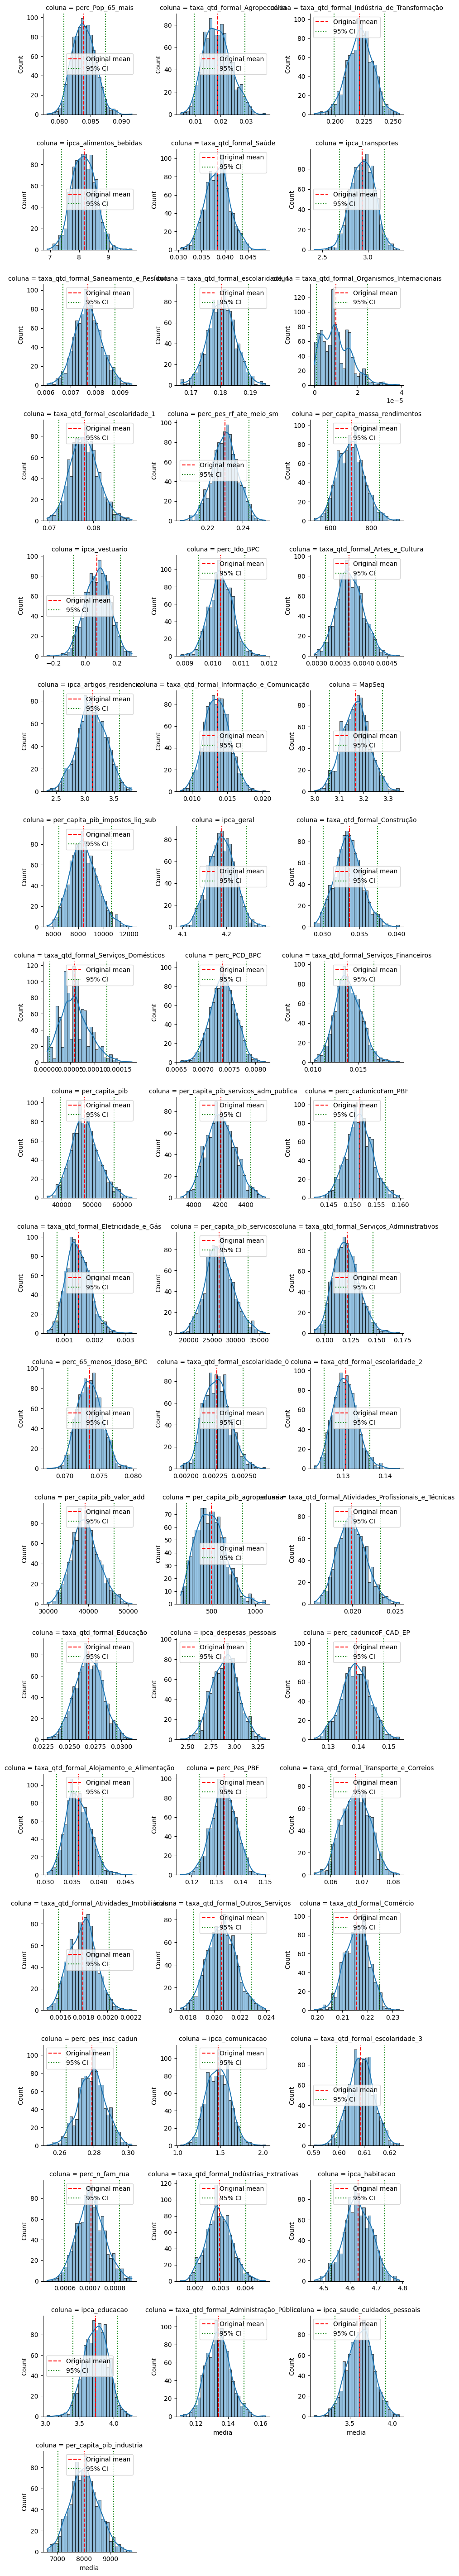

In [ ]:
# exemplo para UMA região
region_example = df_bootstrap['cod_regiao'].unique()[0]

subset = df_bootstrap.query("cod_regiao == @region_example")
original_region = df_regioes.query("cod_regiao == @region_example")

g = sns.FacetGrid(subset, col="coluna", col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, "media", bins=30, kde=True)
for ax, col in zip(g.axes.flat, target_cols):
    orig_value = original_region[col].mean() if col in original_region.columns else None
    if orig_value is not None:
        ax.axvline(orig_value, color='red', linestyle='--', label='Original mean')

    # 95% CI from bootstrap
    boot_data = subset.query("coluna == @col")['media']
    lower_ci, upper_ci = np.percentile(boot_data, [2.5, 97.5])
    ax.axvline(lower_ci, color='green', linestyle=':', label='95% CI')
    ax.axvline(upper_ci, color='green', linestyle=':')
    ax.legend()

plt.tight_layout()
plt.show()

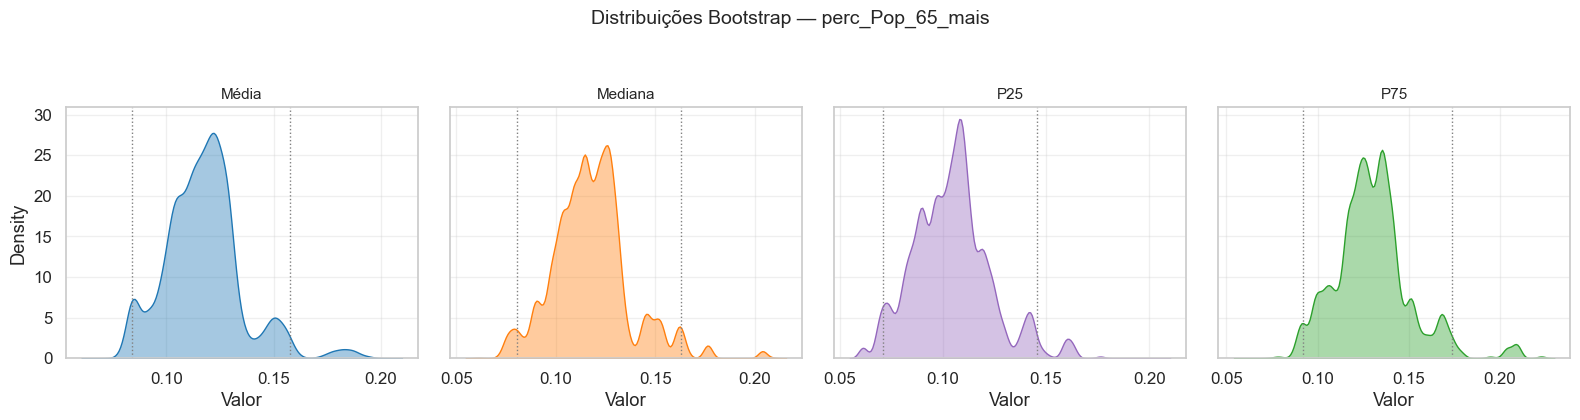

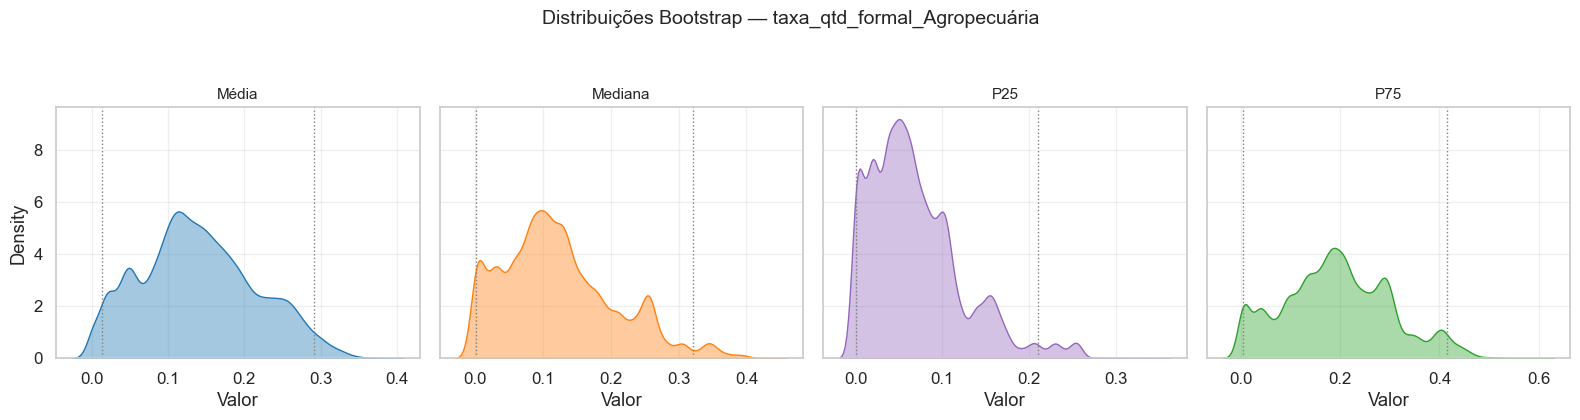

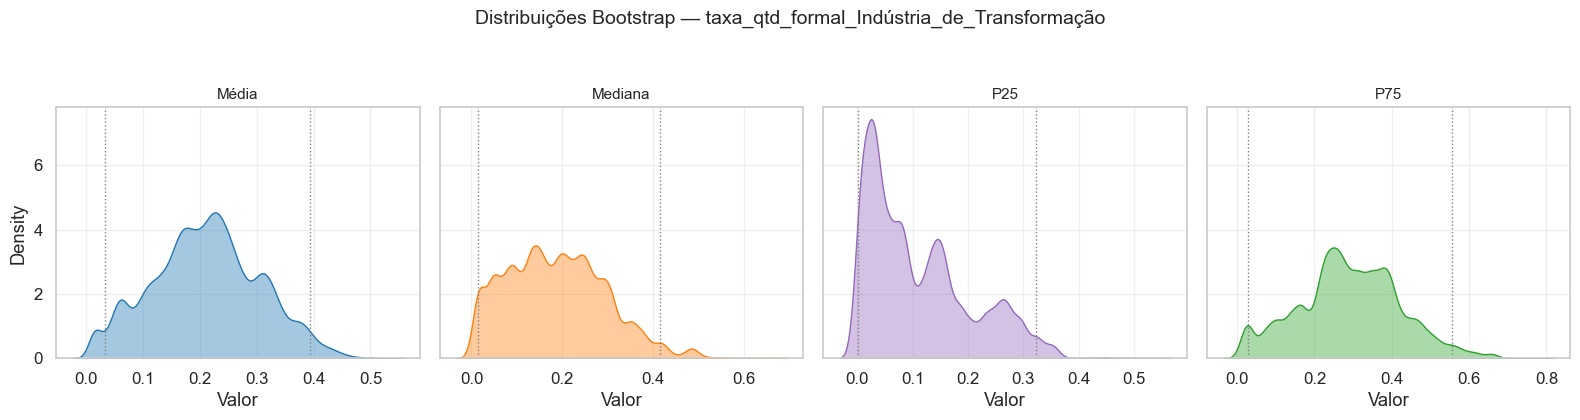

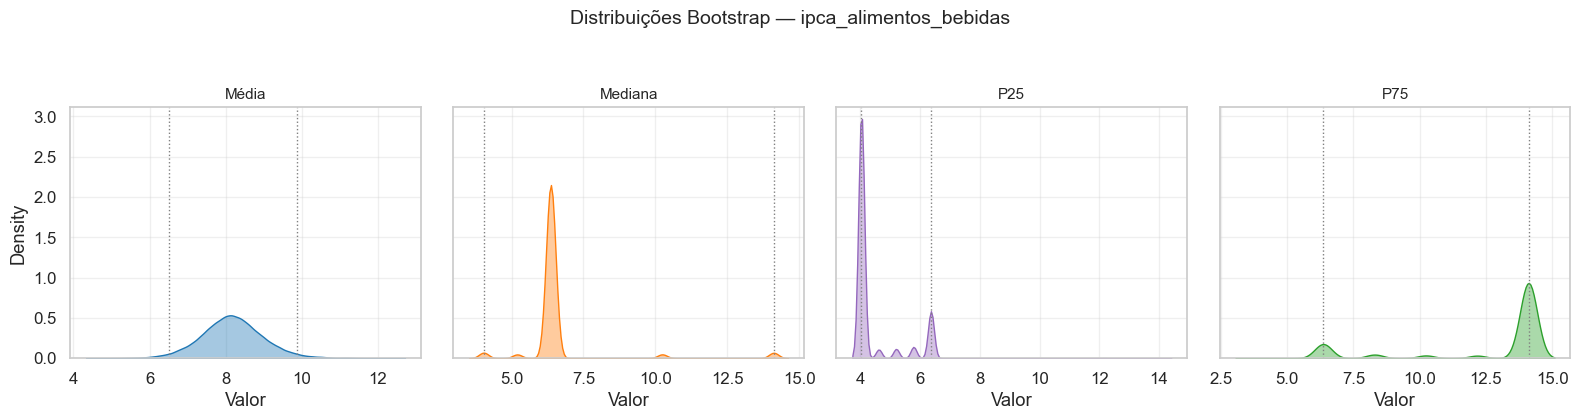

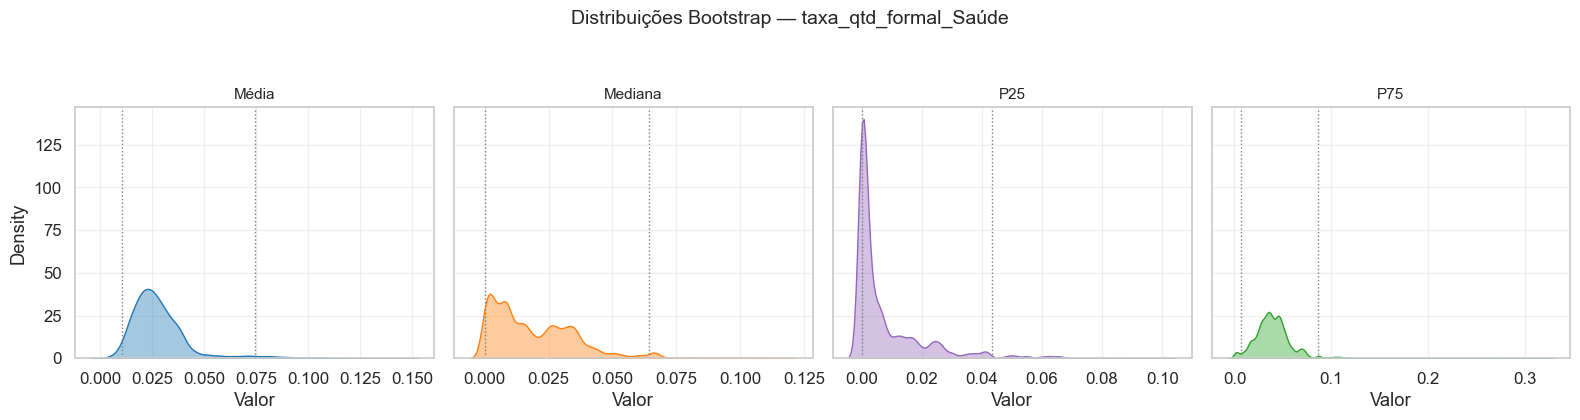

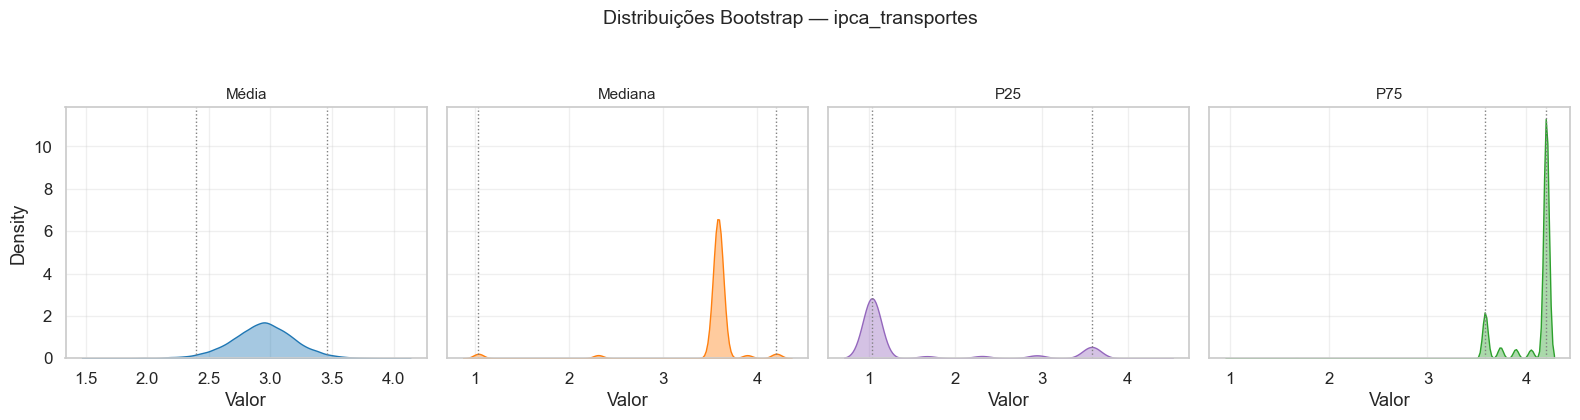

In [94]:
sns.set_theme(style="whitegrid", font_scale=1.1)

# Exemplo: primeiras 6 variáveis
cols_plot = df_bootstrap['coluna'].unique()[:6]

for col in cols_plot:
    df_col = df_bootstrap[df_bootstrap['coluna'] == col]

    fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    fig.suptitle(f"Distribuições Bootstrap — {col}", fontsize=14, y=1.05)

    metrics = ['media', 'mediana', 'p25', 'p75']
    titles = ['Média', 'Mediana', 'P25', 'P75']
    colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#2ca02c']

    for ax, metric, title, color in zip(axes, metrics, titles, colors):
        sns.kdeplot(df_col[metric], fill=True, alpha=0.4, color=color, ax=ax)

        # Intervalo de confiança 95%
        lower_ci, upper_ci = np.percentile(df_col[metric], [2.5, 97.5])
        ax.axvline(lower_ci, color='gray', linestyle=':', linewidth=1)
        ax.axvline(upper_ci, color='gray', linestyle=':', linewidth=1)

        ax.set_title(title, fontsize=11)
        ax.set_xlabel('Valor')
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

In [95]:
df_bootstrap.nome_regiao.value_counts()

nome_regiao
São Paulo                                   55000
Santos                                      55000
Sorocaba                                    55000
Itapeva                                     55000
Registro                                    55000
Itapetininga                                55000
Avaré                                       55000
Tatuí                                       55000
Bauru                                       55000
Jaú                                         55000
Botucatu                                    55000
Lins                                        55000
Marília                                     55000
Assis                                       55000
Ourinhos                                    55000
Tupã                                        55000
Piraju                                      55000
Presidente Prudente                         55000
Adamantina - Lucélia                        55000
Dracena                               

## Reamostragem bootstrap por Região e ano v.2

In [100]:
# =========================================================
# 1. DEFINIÇÃO DAS VARIÁVEIS E PARÂMETROS
# =========================================================

estatisticos = ['media', 'mediana', 'p25', 'p75']
B = 1000  # Número de iterações do bootstrap
regiao_col = 'cod_regiao'
ano_col = 'ano'

# === EXCLUSÃO DE VARIÁVEIS ===
cols_excluir = [
    'ano', 'cod_ibge', 'localidade', 'cod_regiao', 'nome_regiao',
    'MapSeq', 'CD_MUN',
    'pib', 'pib_valor_add', 'pib_agropecuaria', 'pib_industria',
    'pib_servicos', 'pib_servicos_adm_publica', 'pib_impostos_liq_sub',
    'massa_rendimentos_num', 'emprego_formal', 'emp_c_sal',
    'qtd_formal_Administração_Pública', 'qtd_formal_Agropecuária',
    'qtd_formal_Alojamento_e_Alimentação', 'qtd_formal_Artes_e_Cultura',
    'qtd_formal_Atividades_Imobiliárias', 'qtd_formal_Atividades_Profissionais_e_Técnicas',
    'qtd_formal_Comércio', 'qtd_formal_Construção', 'qtd_formal_Educação',
    'qtd_formal_Eletricidade_e_Gás', 'qtd_formal_Indústria_de_Transformação',
    'qtd_formal_Indústrias_Extrativas', 'qtd_formal_Informação_e_Comunicação',
    'qtd_formal_Organismos_Internacionais', 'qtd_formal_Outros_Serviços',
    'qtd_formal_Saneamento_e_Resíduos', 'qtd_formal_Saúde',
    'qtd_formal_Serviços_Administrativos', 'qtd_formal_Serviços_Domésticos',
    'qtd_formal_Serviços_Financeiros', 'qtd_formal_Transporte_e_Correios',
    'qtd_formal_escolaridade_0', 'qtd_formal_escolaridade_1',
    'qtd_formal_escolaridade_2', 'qtd_formal_escolaridade_3', 'qtd_formal_escolaridade_4',
    'Pop_2020', 'Pop_65_mais', '65_menos_Idoso_BPC', 'n_fam_rua',
    'pes_rf_ate_meio_sm', 'pes_insc_cadun', 'Pes_PBF', 'Fam_PBF', 
    'F_CAD_EP', 'Fam_PBF_Aux', 'PCD_BPC', 'Ido_BPC'
]

In [ ]:
# Determinar as colunas numéricas de interesse
all_numeric_cols = set(df_regioes.select_dtypes(include=np.number).columns)
target_cols = list(all_numeric_cols - set(cols_excluir))

print(f"Total de {len(target_cols)} variáveis a serem analisadas por Bootstrap.")
print(f"Agrupando por {df_regioes[regiao_col].nunique()} Regiões e {df_regioes[ano_col].nunique()} Anos.")


Total de 54 variáveis a serem analisadas por Bootstrap.
Agrupando por 53 Regiões e 3 Anos.


In [101]:
# =========================================================
# 2. AGRUPAMENTO POR REGIÃO E ANO
# =========================================================
grouped = df_regioes.groupby([ano_col, regiao_col, 'nome_regiao'])
groups = list(grouped.groups.keys())  # lista de tuplas (ano, cod_regiao, nome_regiao)


In [103]:
# =========================================================
# 3. FUNÇÃO DE UMA ITERAÇÃO DO BOOTSTRAP
# =========================================================
def bootstrap_iteration(seed=None):
    np.random.seed(seed)
    results = {}

    for (ano, cod_regiao, nome_regiao), df_sub in grouped:
        sample = df_sub.sample(n=len(df_sub), replace=True)
        data = sample[target_cols].values  # numpy array para performance

        results[(ano, cod_regiao, nome_regiao)] = {}
        for i, col in enumerate(target_cols):
            col_data = data[:, i]
            col_data = col_data[~np.isnan(col_data)]
            results[(ano, cod_regiao, nome_regiao)][col] = {
                'media': col_data.mean(),
                'mediana': np.median(col_data),
                'p25': np.percentile(col_data, 25),
                'p75': np.percentile(col_data, 75)
            }
    return results

In [106]:
# =========================================================
# 4. EXECUTAR O BOOTSTRAP PARA TODOS OS ANOS EM PARALELO
# =========================================================
results_list = Parallel(n_jobs=-1)(
    delayed(bootstrap_iteration)(seed=i) for i in tqdm(range(B))
)


































































































































100%|██████████| 1000/1000 [13:22<00:00,  1.25it/s]


In [107]:
# =========================================================
# 5. ORGANIZAR OS RESULTADOS EM UM DATAFRAME FINAL
# =========================================================
rows = []
for iteration, result in enumerate(results_list):
    for (ano, cod_regiao, nome_regiao), cols in result.items():
        for col, stats in cols.items():
            row = {
                'iteration': iteration,
                'ano': ano,
                'cod_regiao': cod_regiao,
                'nome_regiao': nome_regiao,
                'coluna': col,
                **stats
            }
            rows.append(row)

df_bootstrap = pd.DataFrame(rows)

## Fazer distribuição media,mediana,p25,p75 de todo df_bootstrap

In [115]:
df_bootstrap['coluna'].unique()

array(['perc_Pop_65_mais', 'taxa_qtd_formal_Agropecuária',
       'taxa_qtd_formal_Indústria_de_Transformação',
       'ipca_alimentos_bebidas', 'taxa_qtd_formal_Saúde',
       'ipca_transportes', 'taxa_qtd_formal_Saneamento_e_Resíduos',
       'taxa_qtd_formal_escolaridade_4',
       'taxa_qtd_formal_Organismos_Internacionais',
       'taxa_qtd_formal_escolaridade_1', 'perc_pes_rf_ate_meio_sm',
       'per_capita_massa_rendimentos', 'ipca_vestuario', 'perc_Ido_BPC',
       'taxa_qtd_formal_Artes_e_Cultura', 'ipca_artigos_residencia',
       'taxa_qtd_formal_Informação_e_Comunicação',
       'per_capita_pib_impostos_liq_sub', 'ipca_geral',
       'taxa_qtd_formal_Construção',
       'taxa_qtd_formal_Serviços_Domésticos', 'perc_PCD_BPC',
       'taxa_qtd_formal_Serviços_Financeiros', 'per_capita_pib',
       'per_capita_pib_servicos_adm_publica', 'perc_cadunicoFam_PBF',
       'taxa_qtd_formal_Eletricidade_e_Gás', 'per_capita_pib_servicos',
       'taxa_qtd_formal_Serviços_Administrativ

In [116]:
cols = [#'perc_Pop_65_mais',
 #'taxa_qtd_formal_Agropecuária',
       #'taxa_qtd_formal_Indústria_de_Transformação',
       'ipca_alimentos_bebidas',
       #'taxa_qtd_formal_escolaridade_4',
       #'taxa_qtd_formal_escolaridade_1',
       'perc_pes_rf_ate_meio_sm',
       'per_capita_massa_rendimentos',
        'perc_Ido_BPC',
       'per_capita_pib',
       #'taxa_qtd_formal_escolaridade_0',
       #'taxa_qtd_formal_escolaridade_2', 
       'per_capita_pib_agropecuaria',
       'perc_pes_insc_cadun',
       'taxa_qtd_formal_escolaridade_3',
       'perc_n_fam_rua',
        'per_capita_pib_industria']

In [114]:
df_bootstrap.head(1)

iteration   ano  cod_regiao nome_regiao            coluna     media  \
0          0  2018      350001   São Paulo  perc_Pop_65_mais  0.080956   

    mediana       p25       p75  
0  0.079262  0.069103  0.089276

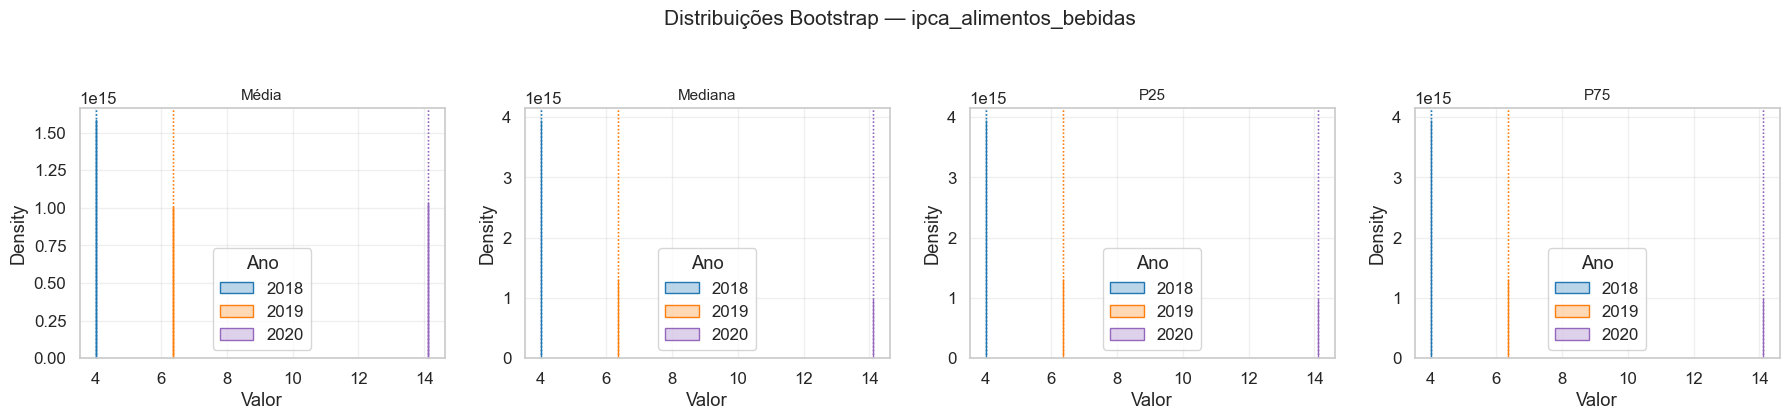

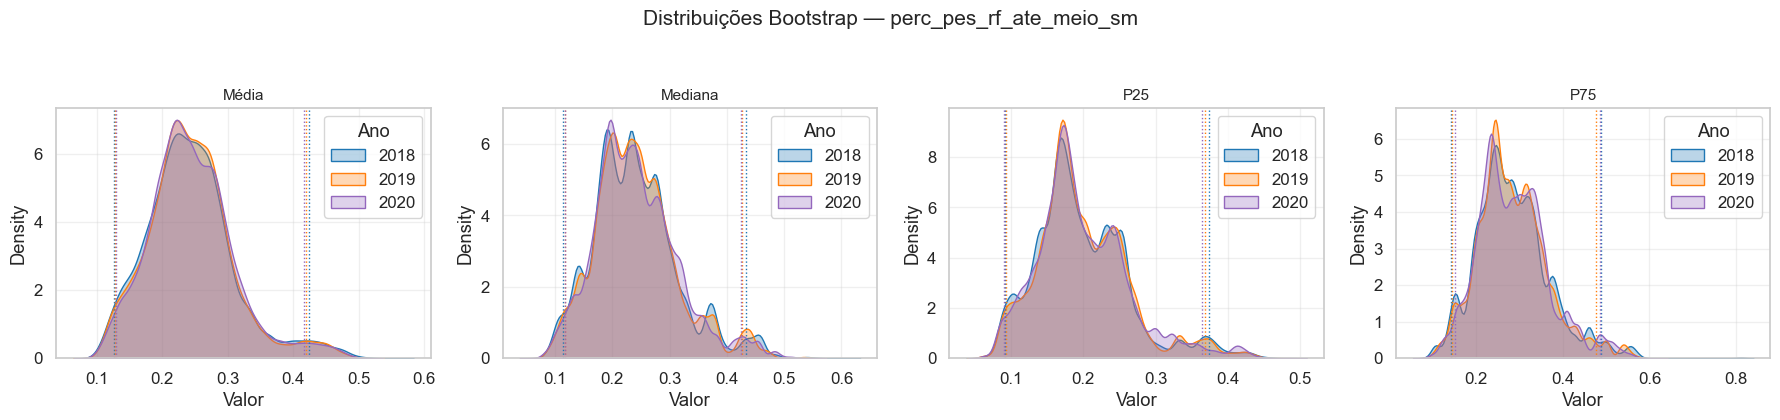

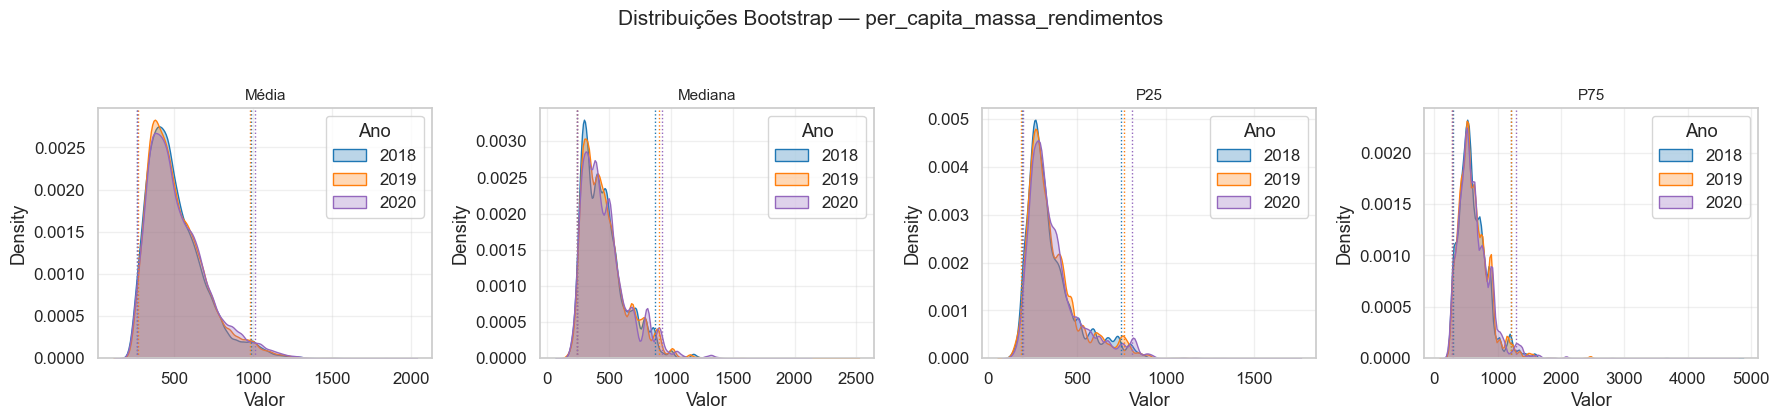

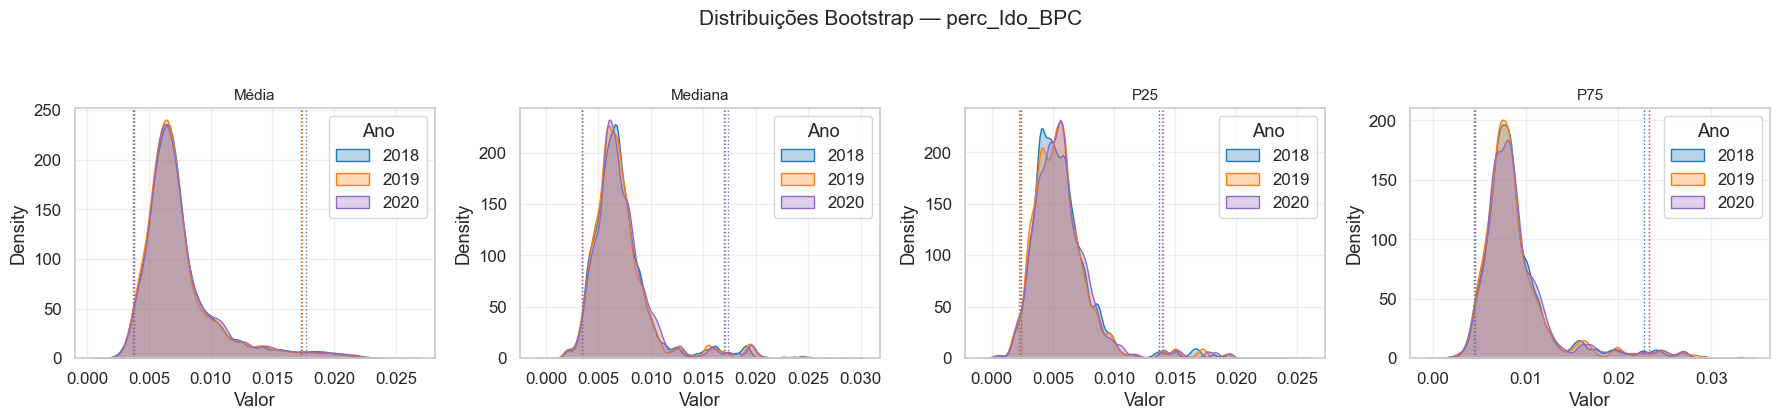

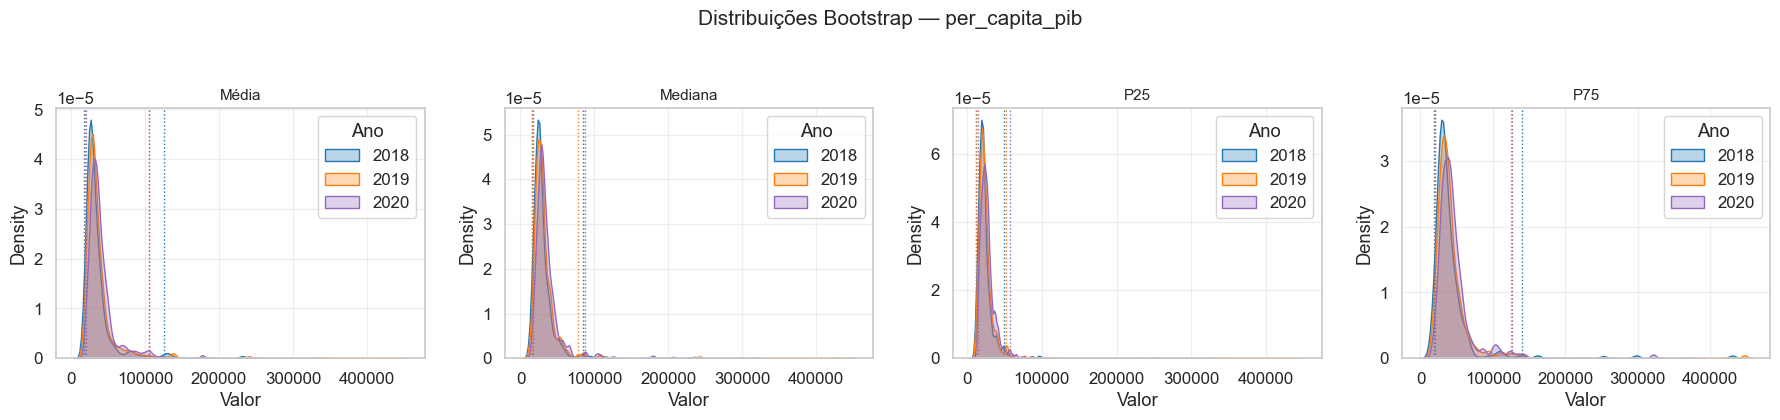

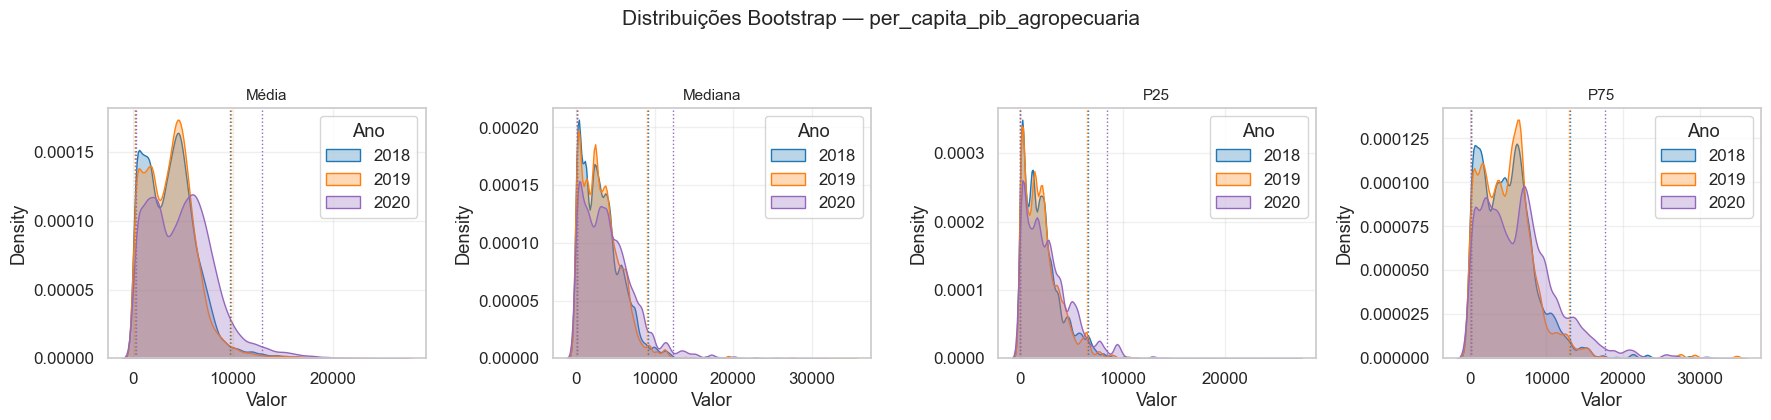

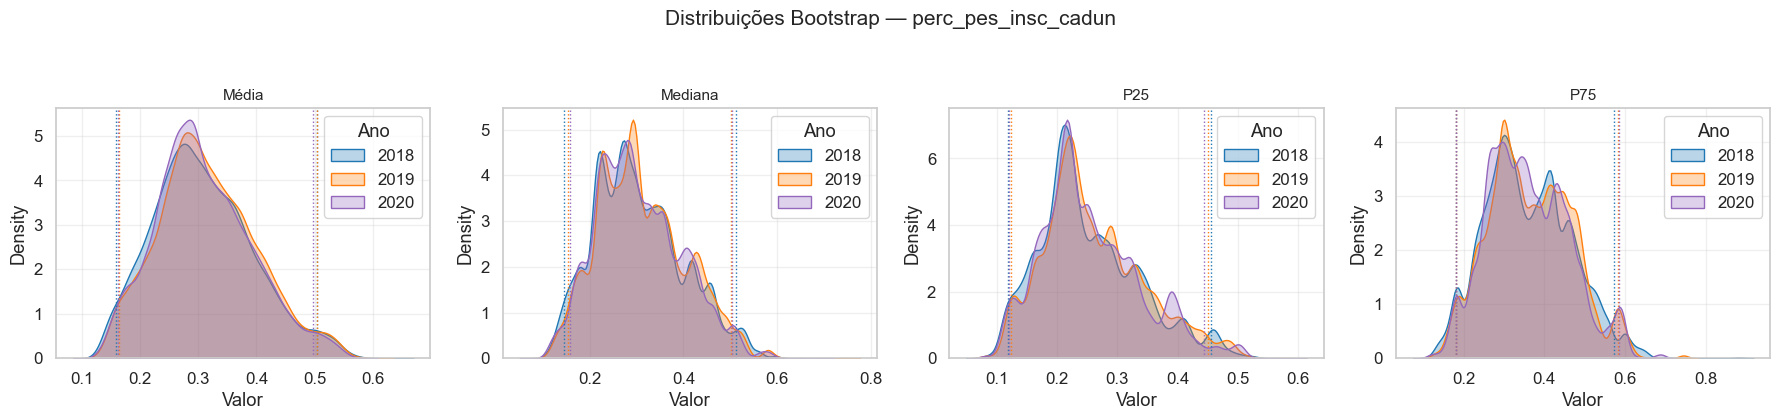

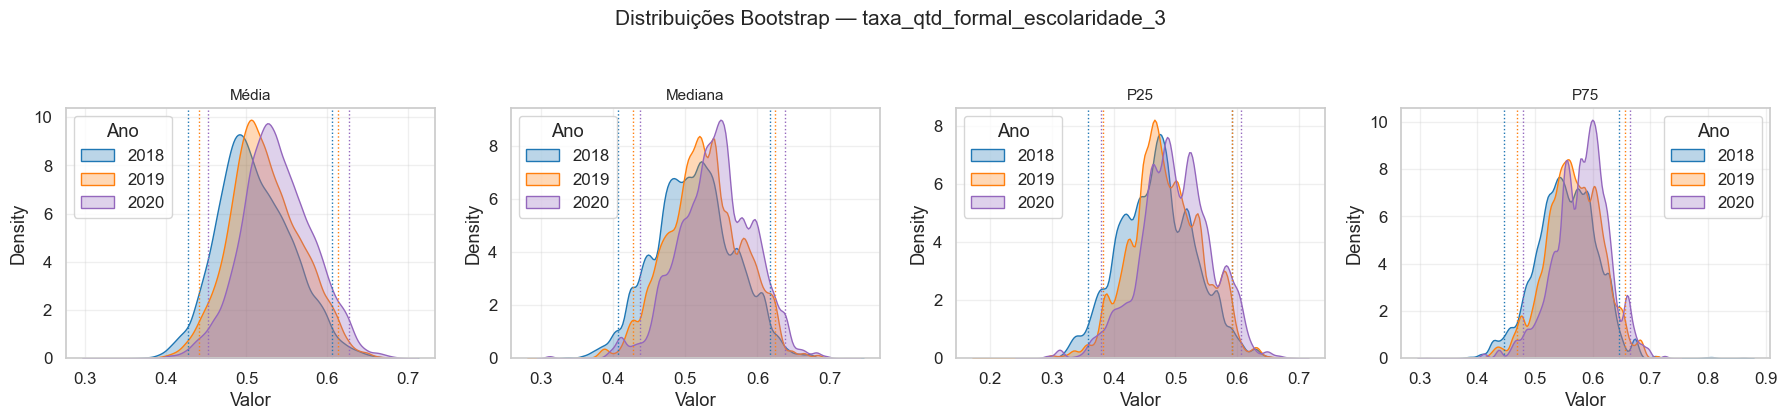

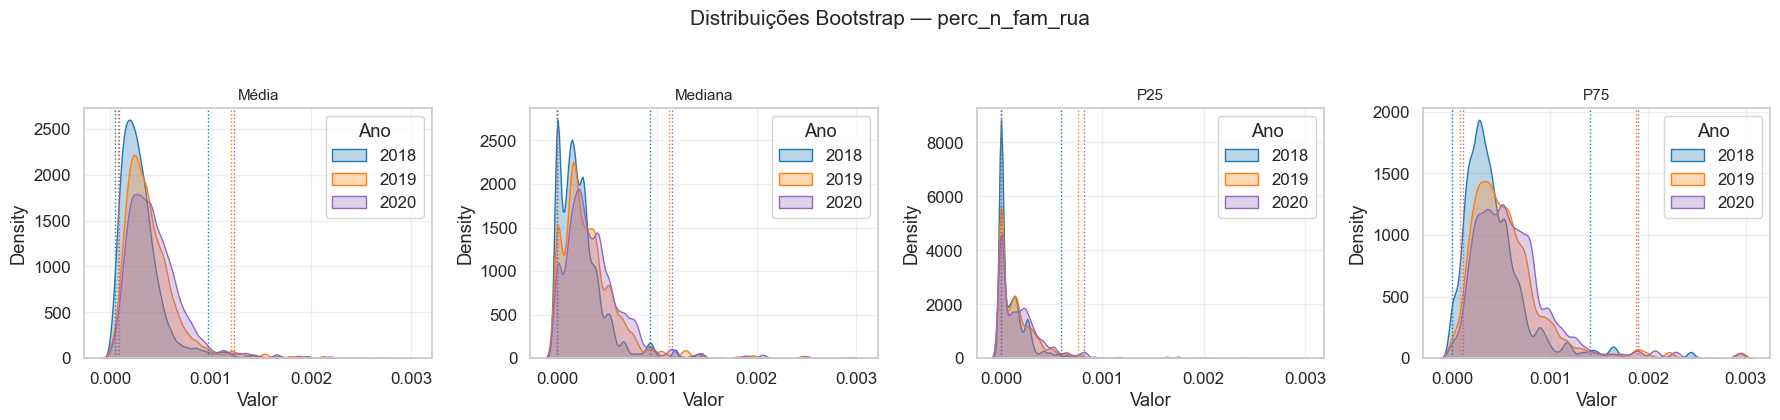

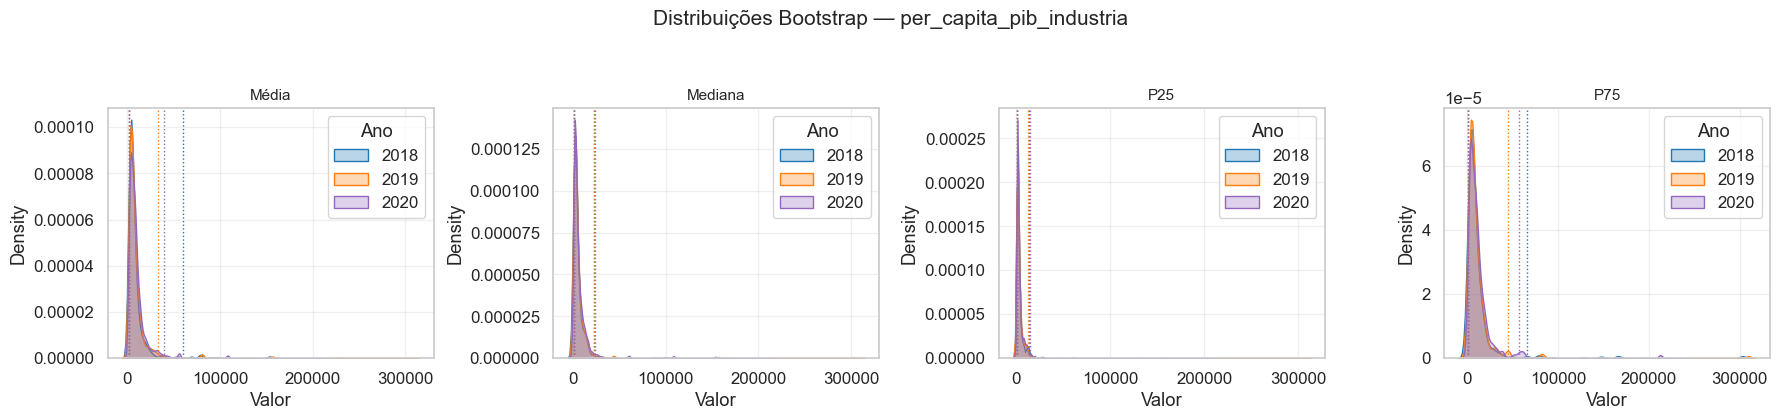

In [117]:
sns.set_theme(style="whitegrid", font_scale=1.1)

# Lista de métricas e títulos correspondentes
metrics = ['media', 'mediana', 'p25', 'p75']
titles = ['Média', 'Mediana', 'P25', 'P75']
colors = ['#1f77b4', '#ff7f0e', '#9467bd']  # uma cor por ano

# Filtra apenas as colunas de interesse
for col in cols:
    df_col = df_bootstrap[df_bootstrap['coluna'] == col]

    fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)
    fig.suptitle(f"Distribuições Bootstrap — {col}", fontsize=15, y=1.05)

    for ax, metric, title in zip(axes, metrics, titles):
        for i, (ano, df_ano) in enumerate(df_col.groupby('ano')):
            sns.kdeplot(
                df_ano[metric],
                fill=True,
                alpha=0.3,
                color=colors[i % len(colors)],
                label=str(ano),
                ax=ax
            )

            # Intervalo de confiança 95% para o ano
            lower_ci, upper_ci = np.percentile(df_ano[metric], [2.5, 97.5])
            ax.axvline(lower_ci, color=colors[i % len(colors)], linestyle=':', linewidth=1)
            ax.axvline(upper_ci, color=colors[i % len(colors)], linestyle=':', linewidth=1)

        ax.set_title(title, fontsize=11)
        ax.set_xlabel('Valor')
        ax.grid(alpha=0.3)
        ax.legend(title='Ano')

    plt.tight_layout()
    plt.show()

## Fazer as distribuições media,mediana,p25,p75 para algumas regiões

pegar uma região com muito municipios , outras com pouco,...

In [ ]:
regioes_plot = ['São Paulo', 'São Carlos', 'Santos']

#São José do Rio Preto , Campinas, 

iteration   ano  cod_regiao nome_regiao            coluna     media  \
0          0  2018      350001   São Paulo  perc_Pop_65_mais  0.080956   

    mediana       p25       p75  
0  0.079262  0.069103  0.089276

C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\970947809.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\970947809.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\970947809.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\970947809.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\970947809.py:23: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\g

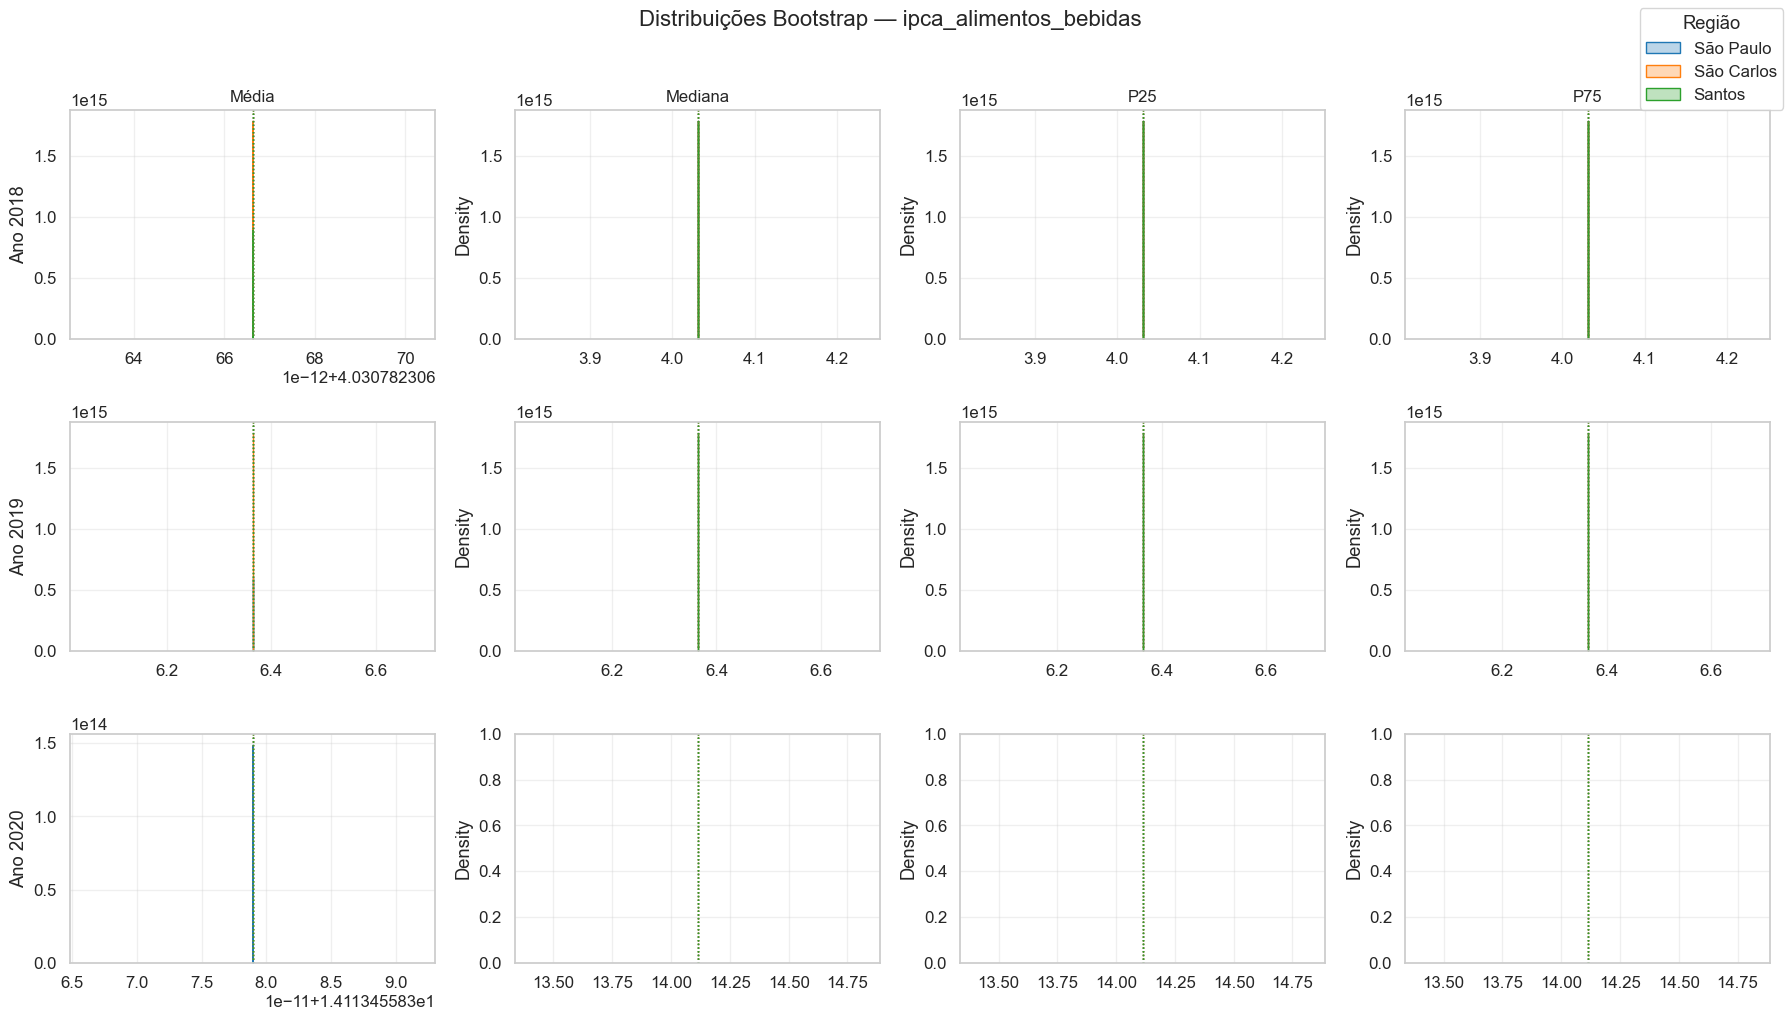

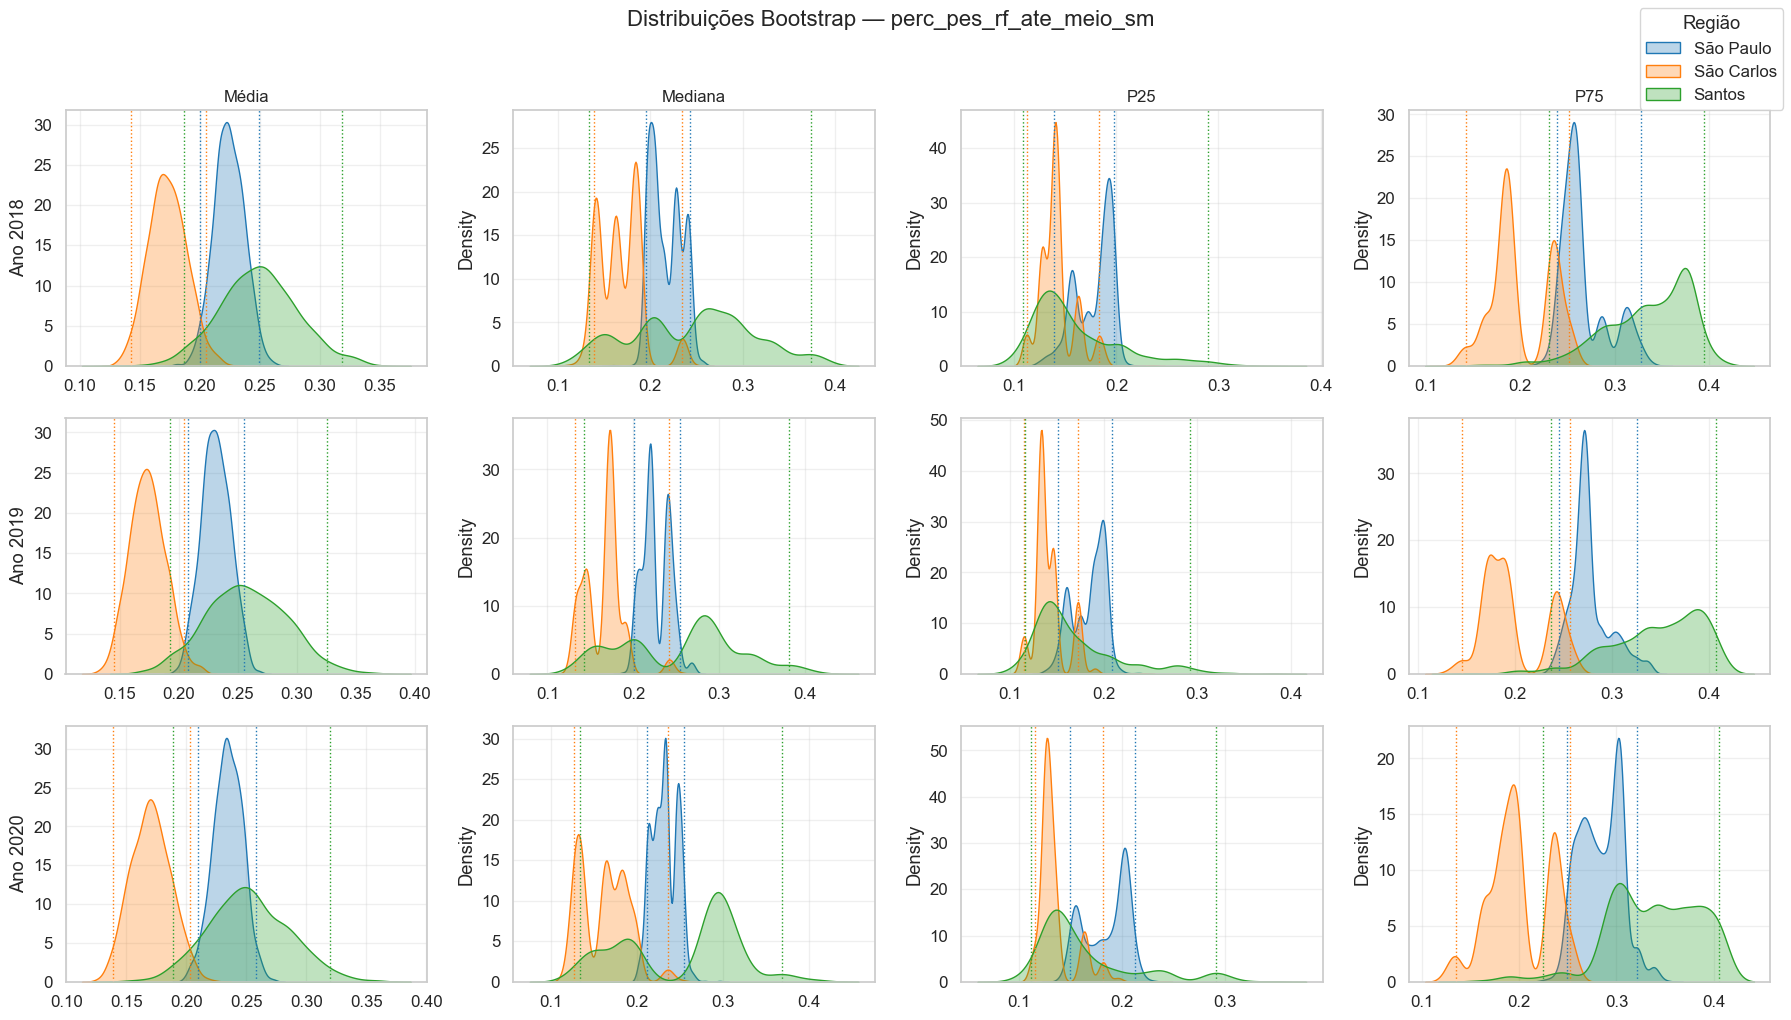

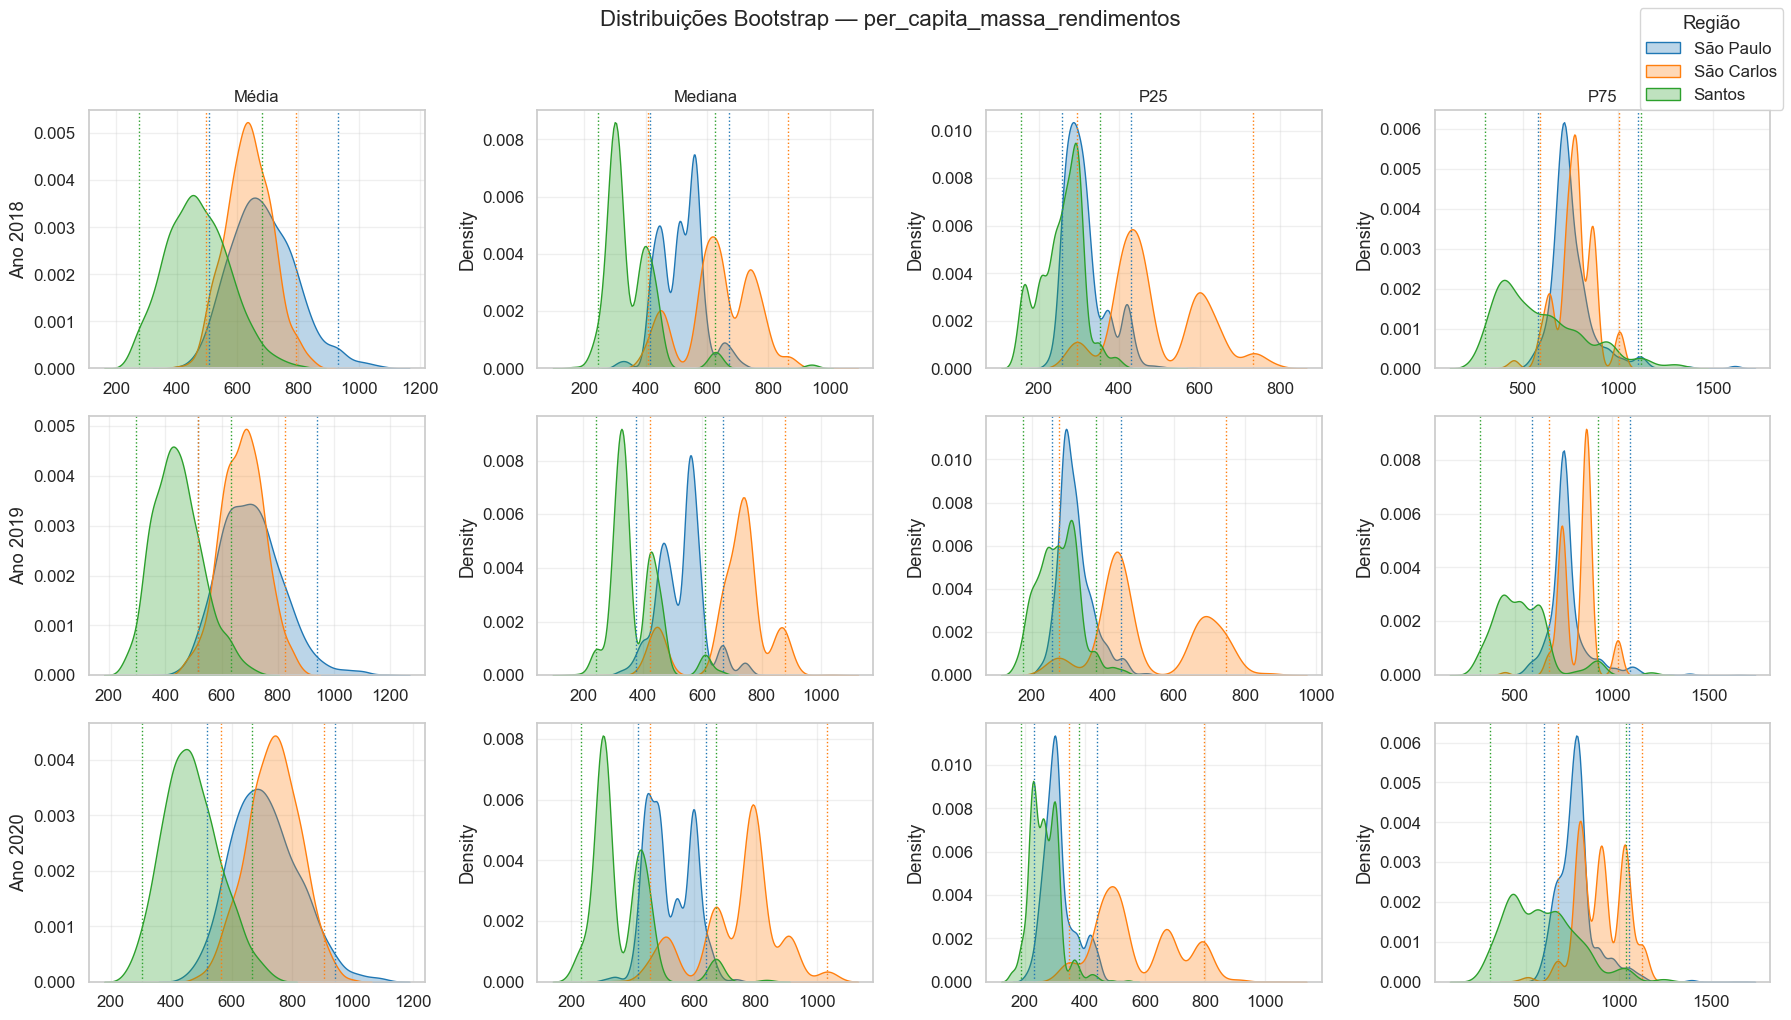

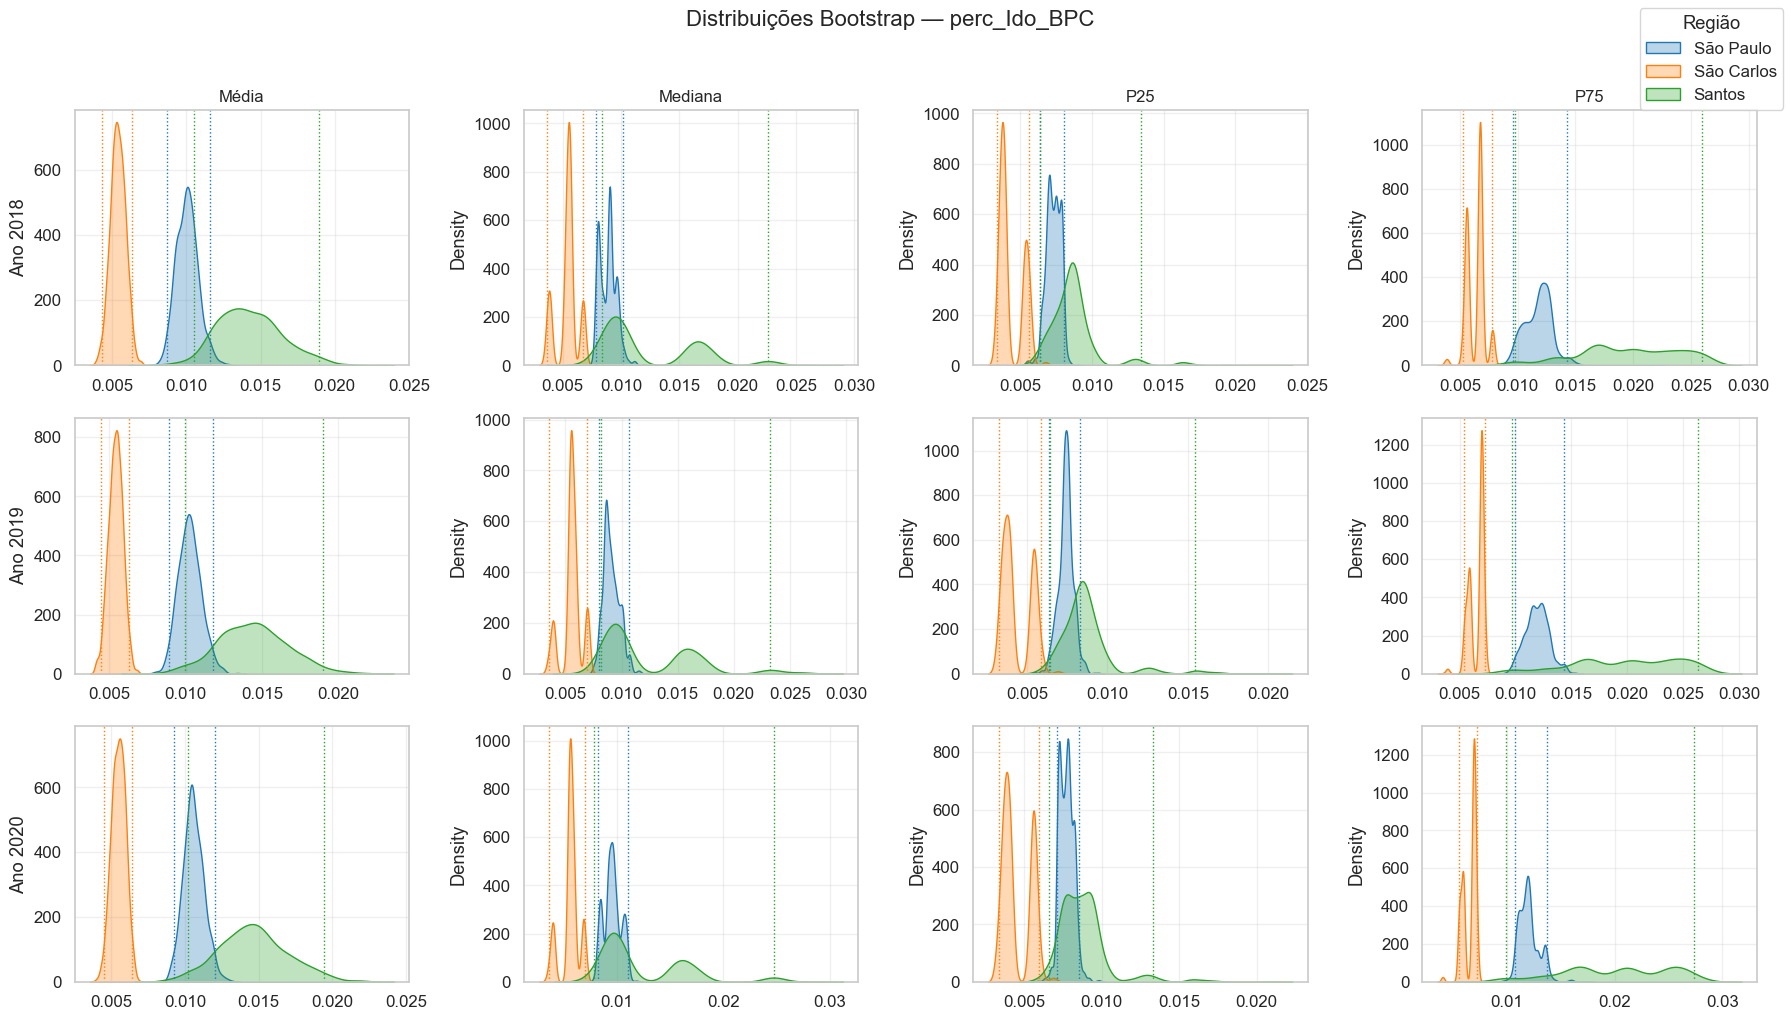

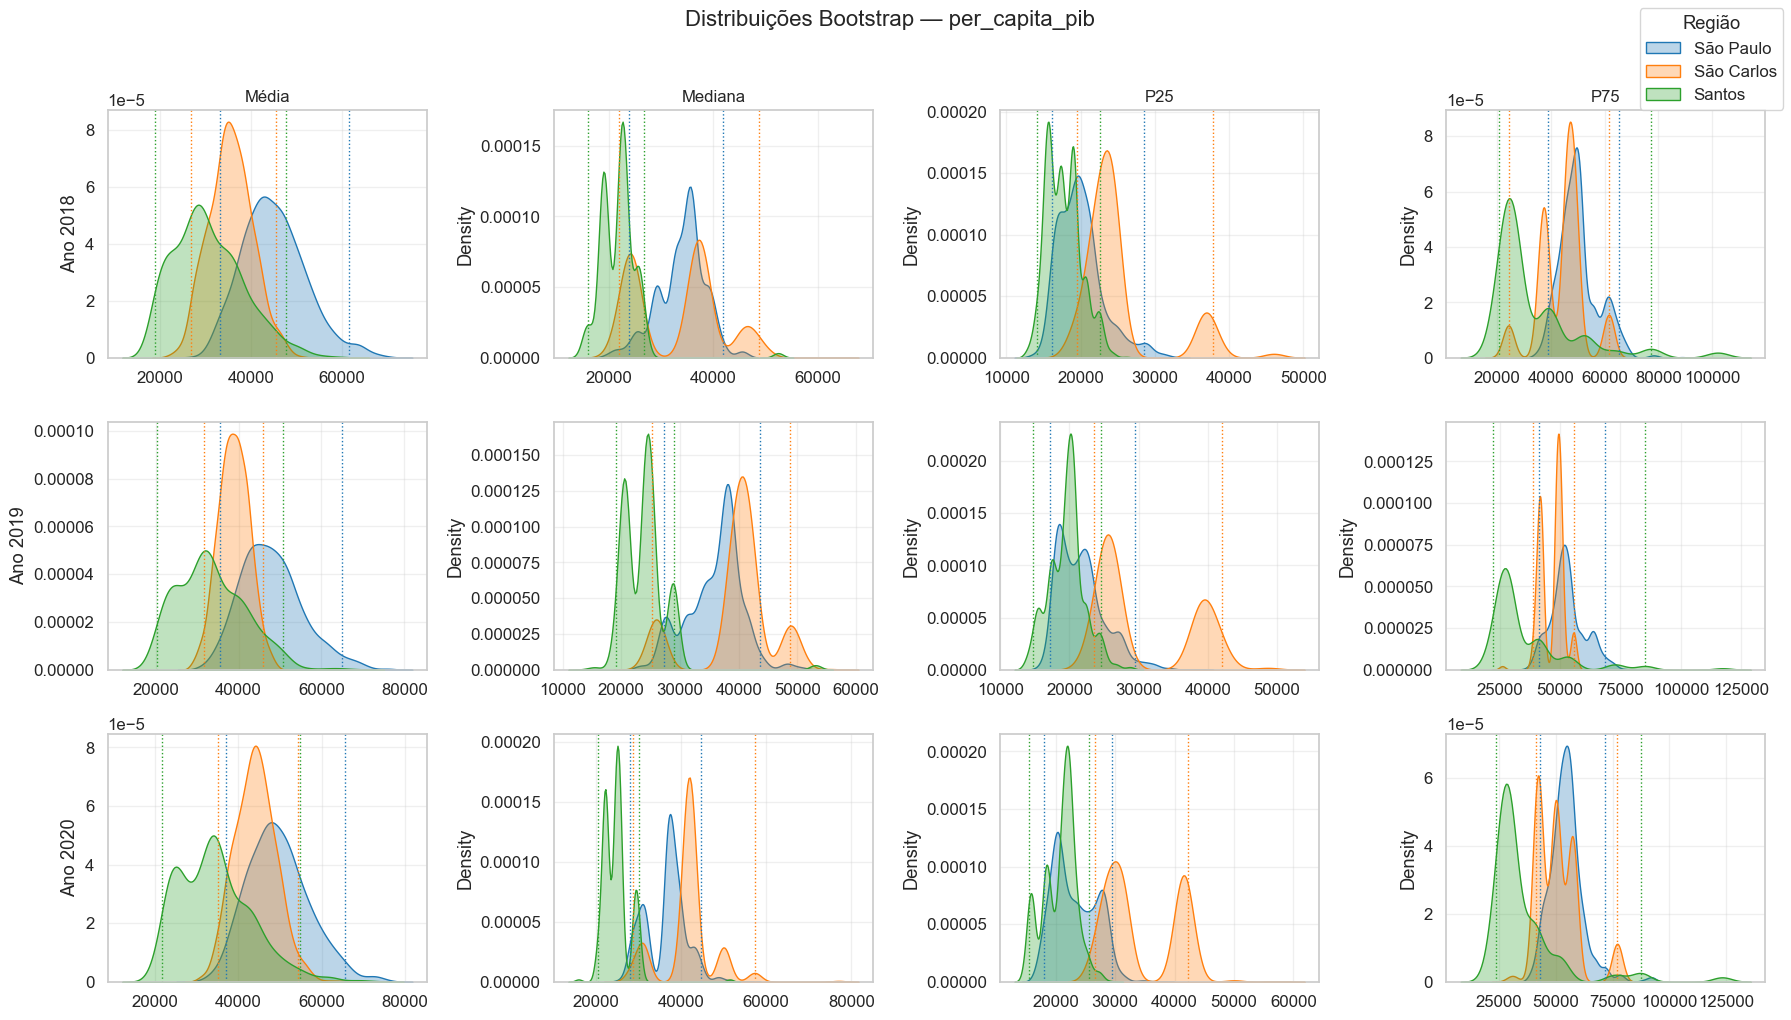

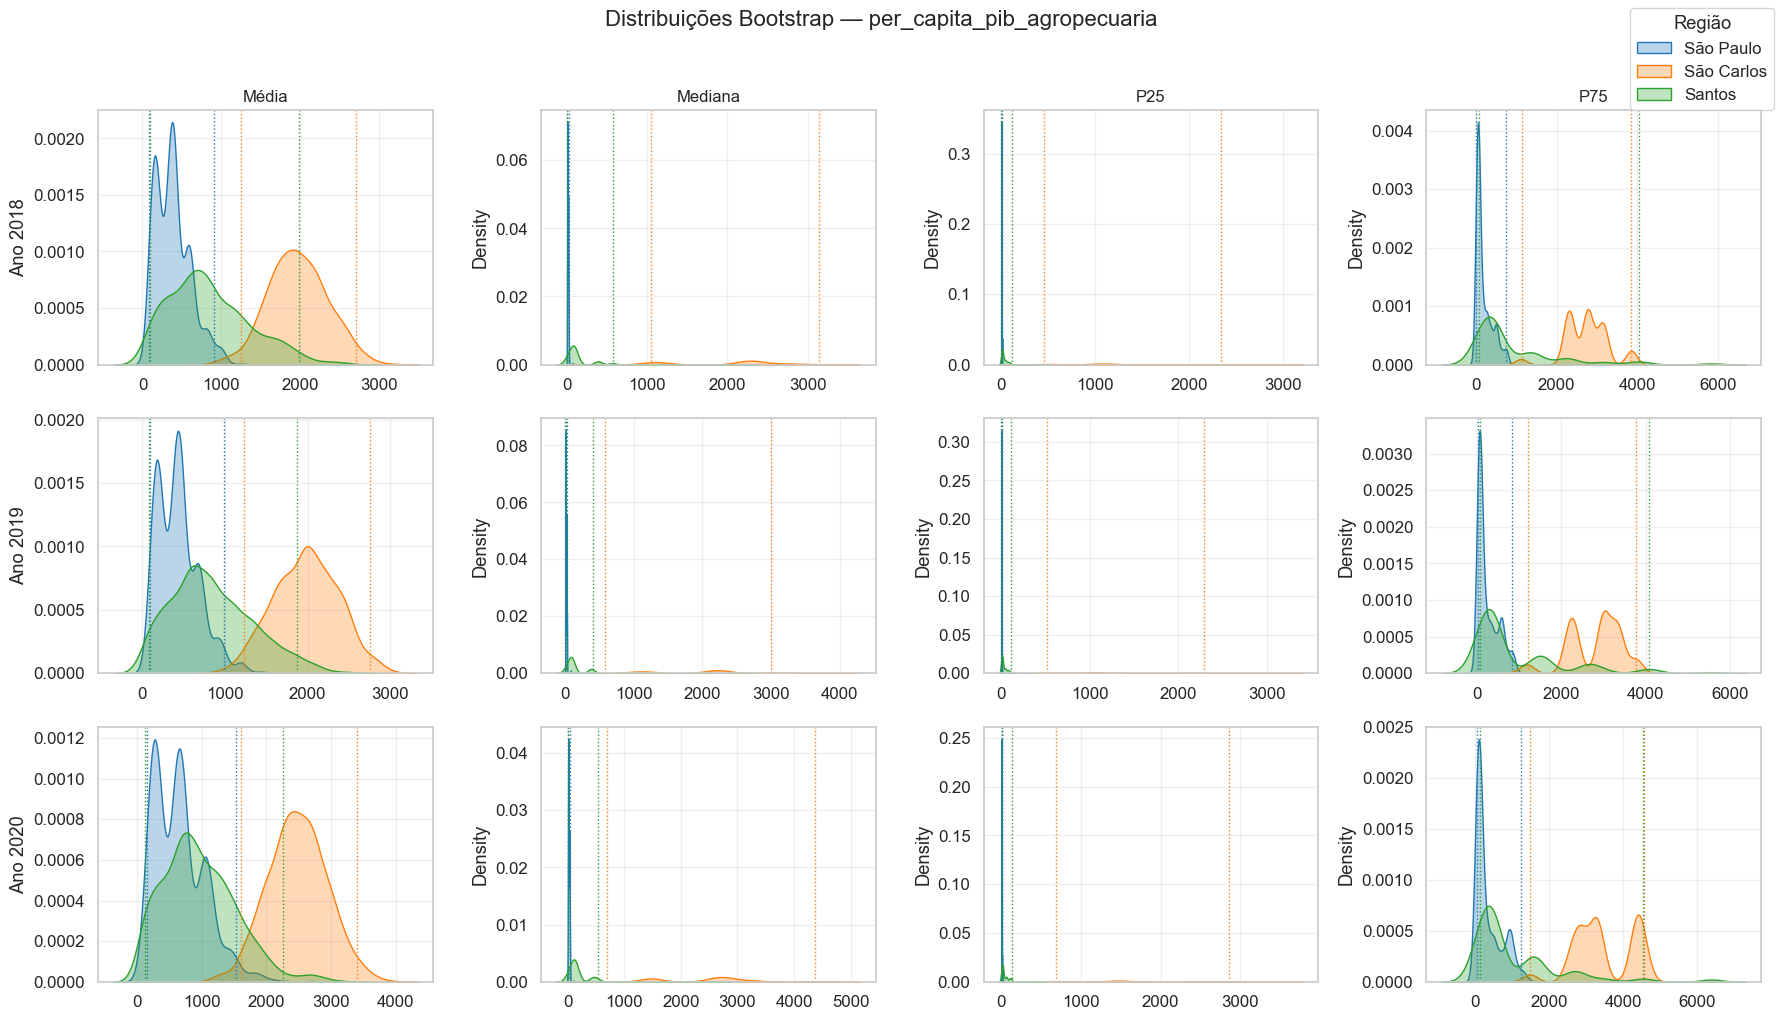

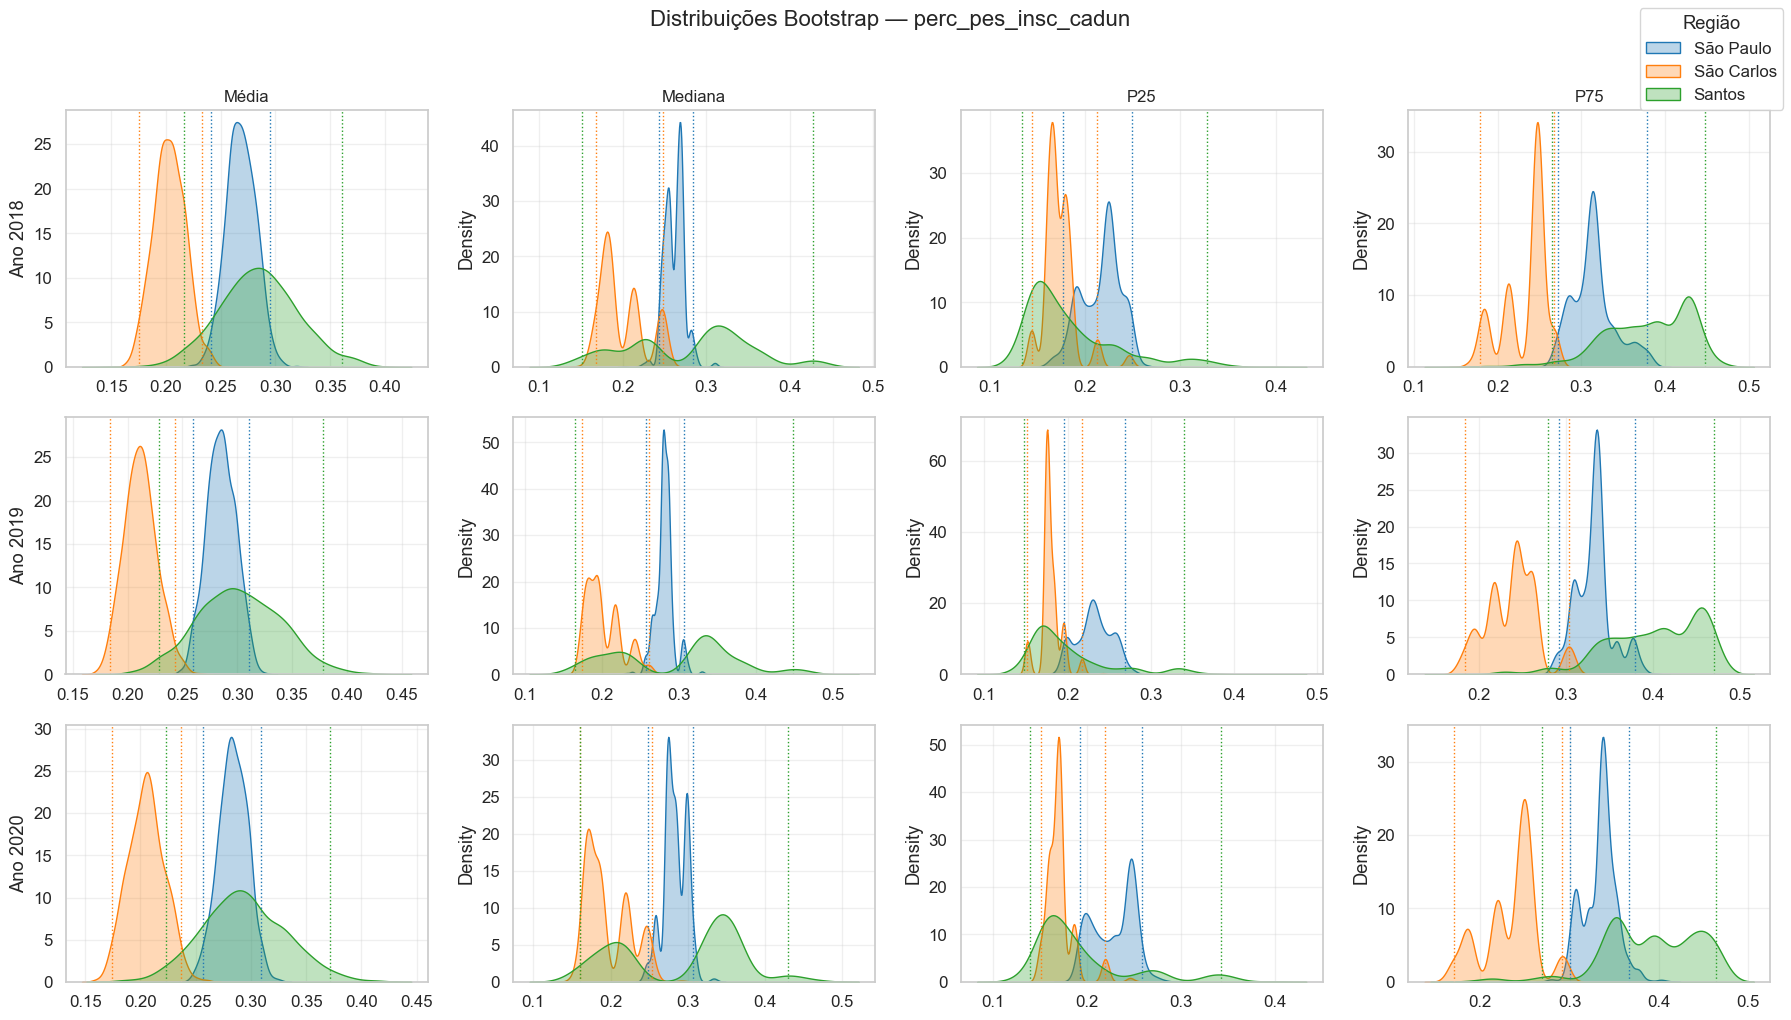

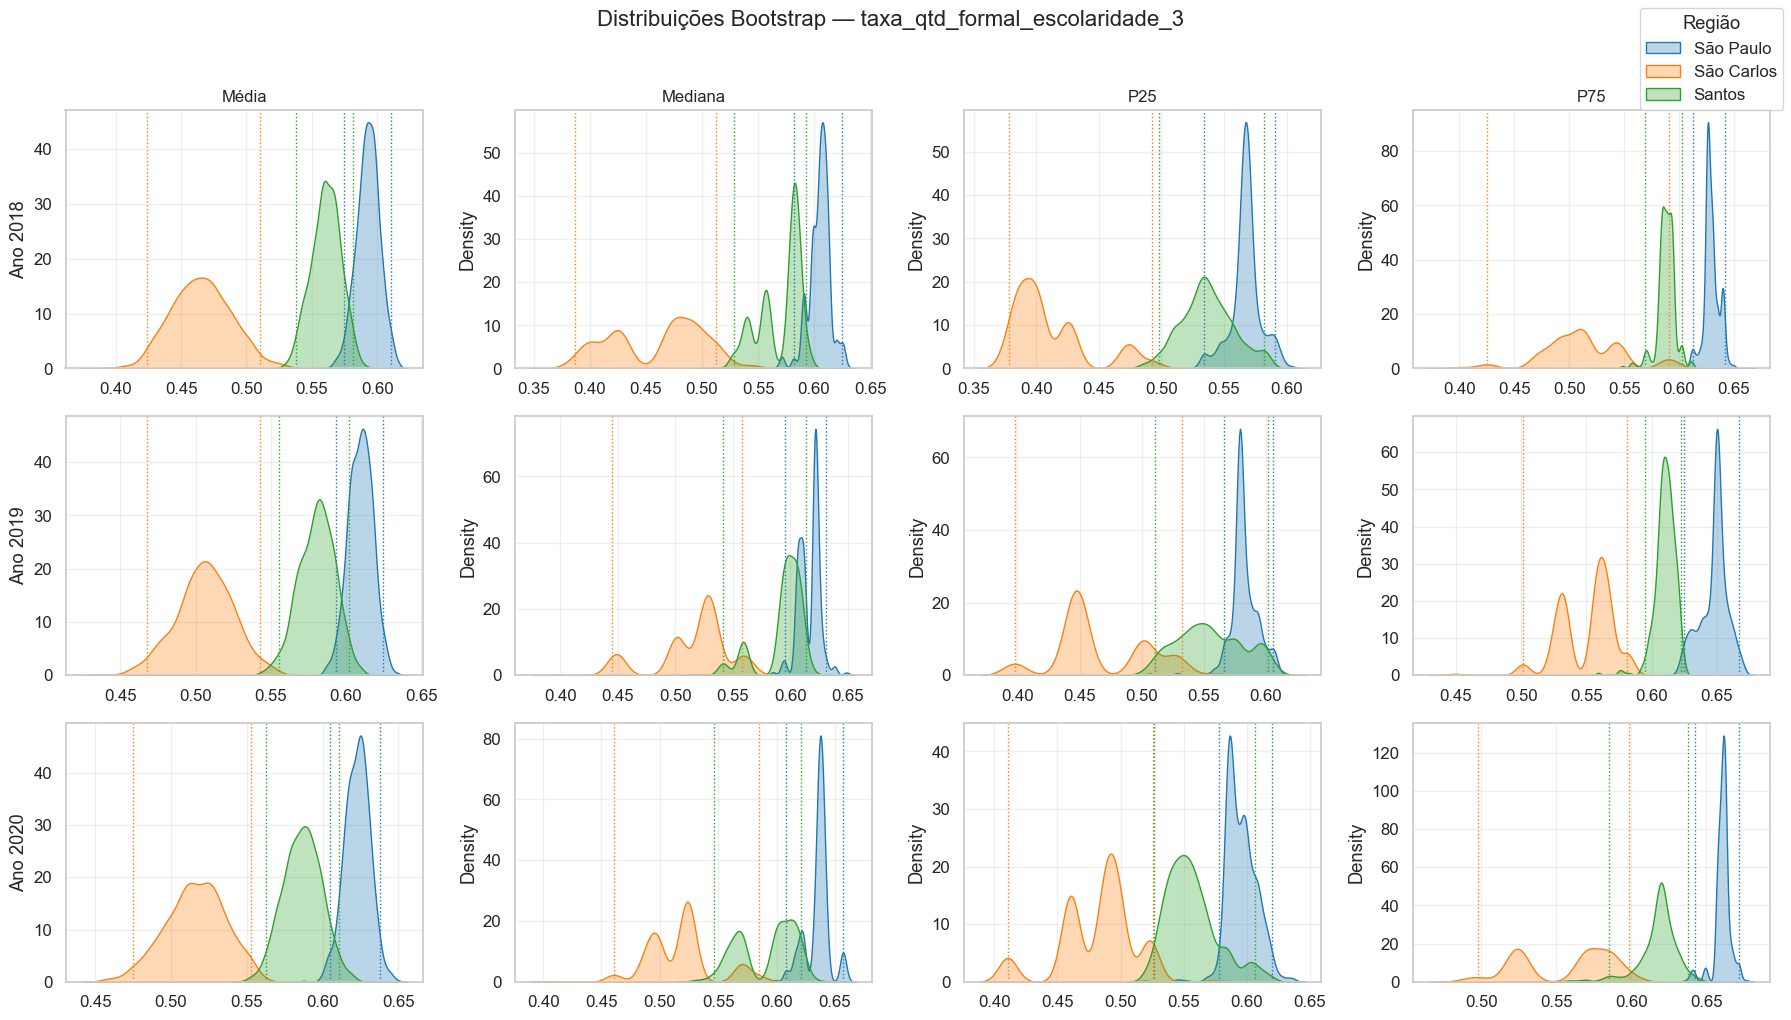

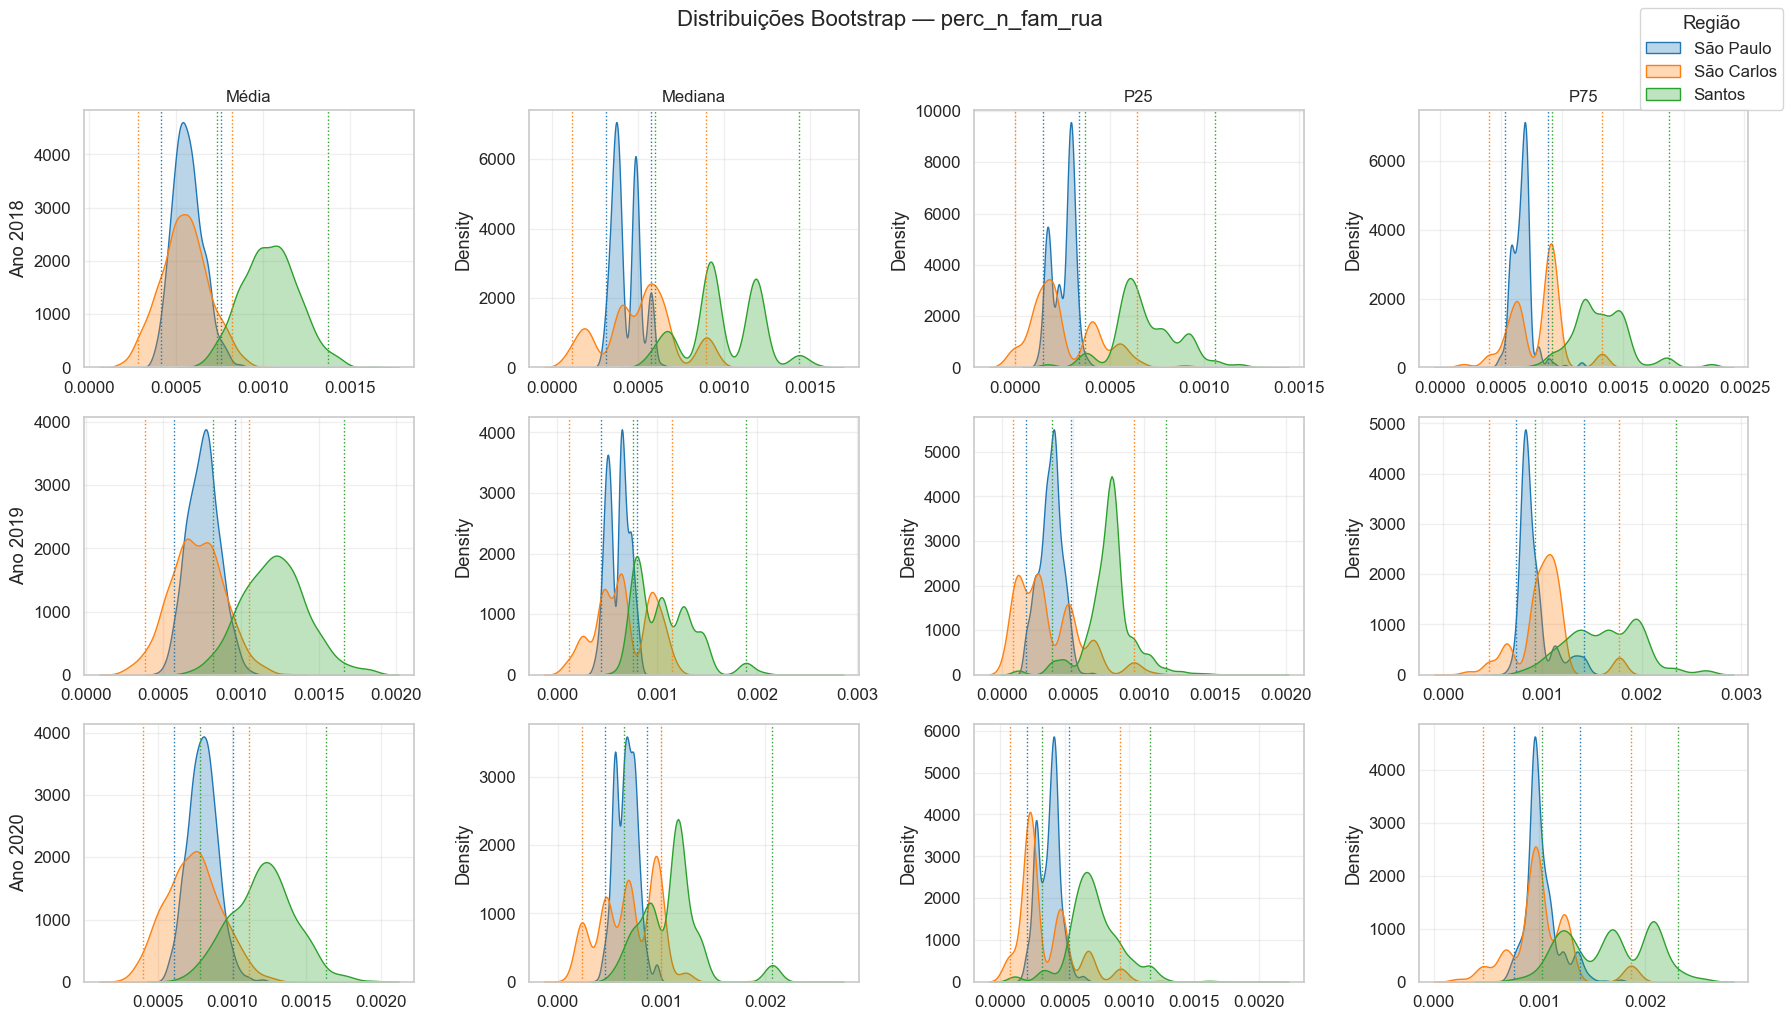

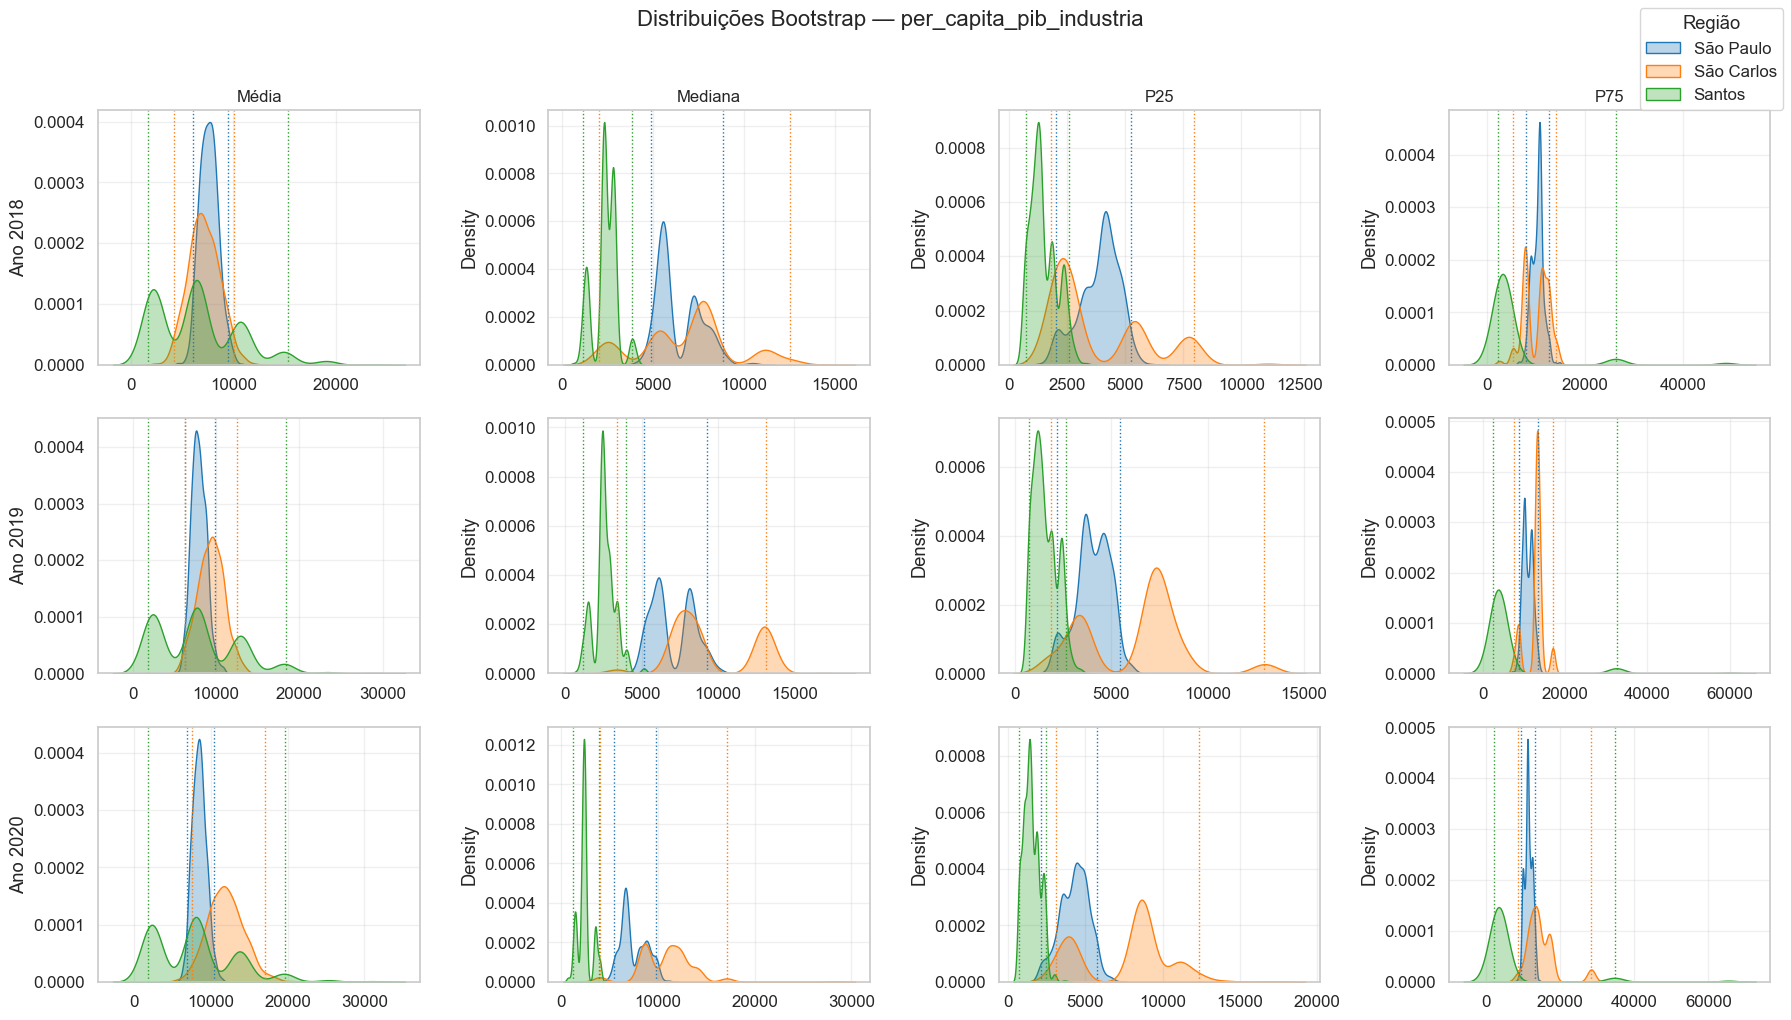

In [129]:
palette = {'São Paulo': '#1f77b4', 'São Carlos': '#ff7f0e', 'Santos': '#2ca02c'}
anos = sorted(df_bootstrap['ano'].unique())

for col in cols:
    df_col = df_bootstrap[(df_bootstrap['coluna'] == col) &
                          (df_bootstrap['nome_regiao'].isin(regioes_plot))]

    fig, axes = plt.subplots(len(anos), len(metrics), figsize=(18, 10), sharey=False)
    fig.suptitle(f"Distribuições Bootstrap — {col}", fontsize=16, y=1.02)

    axes = np.array(axes).reshape(len(anos), len(metrics))

    for i, ano in enumerate(anos):
        df_ano = df_col[df_col['ano'] == ano]

        for j, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[i, j]

            for regiao in regioes_plot:
                df_reg = df_ano[df_ano['nome_regiao'] == regiao]

                if not df_reg.empty:
                    sns.kdeplot(
                        df_reg[metric],
                        fill=True,
                        alpha=0.3,
                        color=palette[regiao],
                        label=regiao,
                        ax=ax
                    )

                    lower_ci, upper_ci = np.percentile(df_reg[metric], [2.5, 97.5])
                    ax.axvline(lower_ci, color=palette[regiao], linestyle=':', linewidth=1)
                    ax.axvline(upper_ci, color=palette[regiao], linestyle=':', linewidth=1)

            if i == 0:
                ax.set_title(title, fontsize=12)
            if j == 0:
                ax.set_ylabel(f"Ano {ano}")

            ax.set_xlabel('')
            ax.grid(alpha=0.3)

    # legenda global
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Região', loc='upper right')

    plt.tight_layout()
    plt.show()


## Criar o summary

escolhido após as distribuições das colunas do bootstrap

In [169]:
# =========================================================
# 5. SUMÁRIO FINAL DO BOOTSTRAP (agregado por região e coluna)
# =========================================================

# summary_bootstrap = (
#     df_bootstrap
#     .groupby(['cod_regiao', 'nome_regiao', 'coluna', 'ano'])
#     .agg(
#         # Média das médias e desvio-padrão
#         media_mean=('media', 'mean'),
#         media_std=('media', 'std'),

#         # Média das medianas e desvio-padrão
#         mediana_mean=('mediana', 'mean'),
#         mediana_std=('mediana', 'std'),

#         # Novo: Mediana da mediana, P25 da mediana e P75 da mediana
#         mediana_mediana=('mediana', 'median'),
#         p25_mediana=('mediana', lambda x: np.percentile(x, 25)),
#         p75_mediana=('mediana', lambda x: np.percentile(x, 75)),

#         # Intervalos de confiança para média (se quiser manter)
#         lower_ci=('media', lambda x: np.percentile(x, 2.5)),
#         upper_ci=('media', lambda x: np.percentile(x, 97.5))
#     )
#     .reset_index()
# )

# print(summary_bootstrap.head())


In [168]:
# summary_bootstrap_1 = (
#     df_bootstrap
#     .groupby(['cod_regiao', 'nome_regiao', 'coluna', 'ano'])
#     .agg(
#         # Média e desvio das médias bootstrap
#         media_mean=('media', 'mean'),
#         media_std=('media', 'std'),

#         # IC 95% da média bootstrap
#         media_ci_lower=('media', lambda x: np.percentile(x, 2.5)),
#         media_ci_upper=('media', lambda x: np.percentile(x, 97.5)),

#         # Mediana e dispersão das medianas bootstrap
#         mediana_mean=('mediana', 'mean'),
#         mediana_std=('mediana', 'std'),
#         mediana_mediana=('mediana', 'median'),
#         p25_mediana=('mediana', lambda x: np.percentile(x, 25)),
#         p75_mediana=('mediana', lambda x: np.percentile(x, 75)),

#         # Incerteza: amplitude do IC e coeficiente de variação (CV)
#         inc_media_amp=('media', lambda x: np.percentile(x, 97.5) - np.percentile(x, 2.5)),
#         inc_media_cv=('media', lambda x: np.std(x) / np.mean(x) if np.mean(x) != 0 else np.nan),
    

#         # Diagnóstico: assimetria e curtose
#         skew_media=('media', lambda x: stats.skew(x, bias=False)),
#         kurt_media=('media', lambda x: stats.kurtosis(x, bias=False))
#     )
#     .reset_index()
# )

safe_skew / safe_kurtosis: calculam assimetria e curtose apenas se houver dados suficientes e variância positiva.

safe_cv: calcula o coeficiente de variação de forma robusta (ignora médias zero ou NaN).

detect_multimodality: tenta detectar quantos “picos” existem na densidade estimada via KDE — uma maneira interessante de ver se a distribuição bootstrap é unimodal, bimodal, etc.

Média e incerteza do estimador (intervalo de confiança de 95%)

media_mean, media_std, media_ci_lower, media_ci_upper



Mediana - Diagnóstico da estabilidade da mediana

mediana_mean, mediana_std, mediana_mediana, p25_mediana, p75_mediana



Incerteza (Quantifica variabilidade relativa)

inc_media_amp (amplitude 95%), inc_media_cv (CV da média)


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats, signal

# --- Funções seguras --- #

def safe_skew(x):
    x = np.array(x.dropna())
    return stats.skew(x, bias=False) if len(x) > 2 and np.std(x) > 0 else np.nan

def safe_kurtosis(x):
    x = np.array(x.dropna())
    return stats.kurtosis(x, bias=False) if len(x) > 2 and np.std(x) > 0 else np.nan

def safe_cv(x):
    x = np.array(x.dropna())
    mean = np.mean(x)
    std = np.std(x)
    return std / mean if len(x) > 1 and mean not in [0, np.nan] else np.nan

def detect_multimodality(x):
    """Detecta número de picos na densidade estimada via KDE (robusto a erros)."""
    x = np.array(x.dropna())
    if len(x) < 10 or np.std(x) == 0:
        return np.nan
    try:
        kde = stats.gaussian_kde(x)
        grid = np.linspace(np.min(x), np.max(x), 200)
        y = kde(grid)
        peaks, _ = signal.find_peaks(y, prominence=np.max(y) * 0.05)
        return len(peaks)
    except Exception:
        return np.nan  # caso o KDE falhe por singularidade

# --- Resumo principal --- #
summary_bootstrap_2 = (
    df_bootstrap
    .groupby(['cod_regiao', 'nome_regiao', 'coluna', 'ano'])
    .agg(
        # Estatísticas principais
        media_mean=('media', 'mean'),
        media_std=('media', 'std'),
        media_ci_lower=('media', lambda x: np.percentile(x.dropna(), 2.5)),
        media_ci_upper=('media', lambda x: np.percentile(x.dropna(), 97.5)),

        # Mediana e dispersão
        mediana_mean=('mediana', 'mean'),
        mediana_std=('mediana', 'std'),
        mediana_mediana=('mediana', 'median'),
        p25_mediana=('mediana', lambda x: np.percentile(x.dropna(), 25)),
        p75_mediana=('mediana', lambda x: np.percentile(x.dropna(), 75)),

        # Incerteza
        inc_media_amp=('media', lambda x: np.percentile(x.dropna(), 97.5) - np.percentile(x.dropna(), 2.5)),
        inc_media_cv=('media', safe_cv),

        # Diagnósticos
        skew_media=('media', safe_skew),
        kurt_media=('media', safe_kurtosis),

        # Multimodalidade
        n_peaks=('media', detect_multimodality)
    )
    .reset_index()
)

# --- Classificação diagnóstica --- #
def classify_row(row):
    """Cria categorias qualitativas de estabilidade e forma."""
    # Estabilidade
    if pd.isna(row['inc_media_cv']):
        estabilidade = 'Sem dados'
    elif row['inc_media_cv'] < 0.05:
        estabilidade = 'Alta estabilidade'
    elif row['inc_media_cv'] < 0.15:
        estabilidade = 'Moderada'
    else:
        estabilidade = 'Alta incerteza'

    # Assimetria
    if pd.isna(row['skew_media']):
        assimetria = 'Sem dados'
    elif abs(row['skew_media']) < 0.3:
        assimetria = 'Simétrica'
    elif row['skew_media'] > 0:
        assimetria = 'Assimétrica à direita'
    else:
        assimetria = 'Assimétrica à esquerda'

    # Curtose
    if pd.isna(row['kurt_media']):
        curtose = 'Sem dados'
    elif row['kurt_media'] > 3:
        curtose = 'Leptocúrtica (pico alto)'
    elif row['kurt_media'] < -1:
        curtose = 'Platicúrtica (achatada)'
    else:
        curtose = 'Mesocúrtica (normal)'

    # Multimodalidade
    if pd.isna(row['n_peaks']):
        multimodalidade = 'Sem dados'
    elif row['n_peaks'] == 1:
        multimodalidade = 'Unimodal'
    elif row['n_peaks'] == 2:
        multimodalidade = 'Bimodal'
    else:
        multimodalidade = 'Multimodal'

    return pd.Series({
        'diagnostico_estabilidade': estabilidade,
        'diagnostico_assimetria': assimetria,
        'diagnostico_curtose': curtose,
        'diagnostico_multimodal': multimodalidade
    })

# Aplica a classificação
diagnosticos = summary_bootstrap_2.apply(classify_row, axis=1)
summary_bootstrap_2 = pd.concat([summary_bootstrap_2, diagnosticos], axis=1)


C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\2969692015.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.skew(x, bias=False) if len(x) > 2 and np.std(x) > 0 else np.nan
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\2969692015.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return stats.kurtosis(x, bias=False) if len(x) > 2 and np.std(x) > 0 else np.nan


cod_regiao nome_regiao                   coluna   ano  media_mean  \
0      350001   São Paulo   ipca_alimentos_bebidas  2018    4.030782   
1      350001   São Paulo   ipca_alimentos_bebidas  2019    6.364091   
2      350001   São Paulo   ipca_alimentos_bebidas  2020   14.113456   
3      350001   São Paulo  ipca_artigos_residencia  2018    3.759616   
4      350001   São Paulo  ipca_artigos_residencia  2019   -0.377431   

   media_std  media_ci_lower  media_ci_upper  mediana_mean  mediana_std  \
0        0.0        4.030782        4.030782      4.030782          0.0   
1        0.0        6.364091        6.364091      6.364091          0.0   
2        0.0       14.113456       14.113456     14.113456          0.0   
3        0.0        3.759616        3.759616      3.759616          0.0   
4        0.0       -0.377431       -0.377431     -0.377431          0.0   

   mediana_mediana  p25_mediana  p75_mediana  inc_media_amp  inc_media_cv  \
0         4.030782     4.030782     4.030782            0.0  4.406978e-16   
1         6.364091     6.364091     6.364091            0.0  1.395609e-16   
2        14.113456    14.113456    14.113456            0.0  1.258626e-16   
3         3.759616     3.759616     3.759616            0.0  3.543627e-16   
4        -0.377431    -0.377431    -0.377431            0.0 -1.470762e-16   

   skew_media  kurt_media  n_peaks diagnostico_estabilidade  \
0    1.001503   -2.004012      0.0        Alta estabilidade   
1         NaN         NaN      0.0        Alta estabilidade   
2         NaN         NaN      0.0        Alta estabilidade   
3    1.001503   -2.004012      0.0        Alta estabilidade   
4         NaN         NaN      0.0        Alta estabilidade   

  diagnostico_assimetria      diagnostico_curtose diagnostico_multimodal  
0  Assimétrica à direita  Platicúrtica (achatada)             Multimodal  
1              Sem dados                Sem dados             Multimodal  
2              Sem dados                Sem dados             Multimodal  
3  Assimétrica à direita  Platicúrtica (achatada)             Multimodal  
4              Sem dados                Sem dados             Multimodal

Multimodal, isso indica que:

O seu conjunto de dados pode representar subpopulações diferentes (ex: regiões ou períodos muito heterogêneos);

Ou que a estatística não é estável — pequenas mudanças na amostra levam a estimativas muito diferentes.

## Verificar o diagnostico do summary

aqui verificar o caso da multimodalidade: é problema de heterogeneidade estrutural?? em uma msm região tem cidades ricas e cidades pobres

In [145]:
summary_bootstrap_2.diagnostico_multimodal.value_counts()

diagnostico_multimodal
Unimodal      5953
Multimodal    1735
Sem dados      663
Bimodal        235
Name: count, dtype: int64

In [146]:
summary_bootstrap_2.diagnostico_estabilidade.value_counts()

diagnostico_estabilidade
Alta incerteza       3810
Moderada             2465
Alta estabilidade    2094
Sem dados             217
Name: count, dtype: int64

In [161]:
summary_bootstrap_2.n_peaks.value_counts()

n_peaks
1.0    5953
0.0    1144
3.0     402
2.0     235
4.0     187
5.0       2
Name: count, dtype: int64

In [157]:
summary_bootstrap_2.query('diagnostico_multimodal == "Bimodal" and nome_regiao == "Santos"')

cod_regiao nome_regiao                        coluna   ano    media_mean  \
197      350002      Santos                per_capita_pib  2020  34443.442626   
215      350002      Santos      per_capita_pib_valor_add  2020  31131.848441   
251      350002      Santos  taxa_qtd_formal_Agropecuária  2020      0.029036   

       media_std  media_ci_lower  media_ci_upper  mediana_mean  mediana_std  \
197  8855.590626    21806.310295    54766.795800  24820.339514  3170.992340   
215  7623.974879    20443.968691    48230.086701  23195.011881  2504.003098   
251     0.017413        0.001589        0.069473      0.003441     0.012201   

     mediana_mediana   p25_mediana   p75_mediana  inc_media_amp  inc_media_cv  \
197     24752.939231  22315.411866  25606.400705   32960.485505      0.256977   
215     23638.355810  21109.917524  23910.460571   27786.118009      0.244771   
251         0.001554      0.001270      0.003528       0.067884      0.599400   

     skew_media  kurt_media  n_peaks diagnostico_estabilidade  \
197    0.799705    0.799814      2.0           Alta incerteza   
215    0.818884    0.844907      2.0           Alta incerteza   
251    0.557289    0.235624      2.0           Alta incerteza   

    diagnostico_assimetria   diagnostico_curtose diagnostico_multimodal  
197  Assimétrica à direita  Mesocúrtica (normal)                Bimodal  
215  Assimétrica à direita  Mesocúrtica (normal)                Bimodal  
251  Assimétrica à direita  Mesocúrtica (normal)                Bimodal

In [159]:
summary_bootstrap_2.query('diagnostico_multimodal == "Multimodal" and nome_regiao == "Santos"')

cod_regiao nome_regiao                                      coluna   ano  \
162      350002      Santos                      ipca_alimentos_bebidas  2018   
165      350002      Santos                     ipca_artigos_residencia  2018   
166      350002      Santos                     ipca_artigos_residencia  2019   
167      350002      Santos                     ipca_artigos_residencia  2020   
168      350002      Santos                            ipca_comunicacao  2018   
169      350002      Santos                            ipca_comunicacao  2019   
170      350002      Santos                            ipca_comunicacao  2020   
172      350002      Santos                      ipca_despesas_pessoais  2019   
173      350002      Santos                      ipca_despesas_pessoais  2020   
175      350002      Santos                               ipca_educacao  2019   
176      350002      Santos                               ipca_educacao  2020   
177      350002      Santos                                  ipca_geral  2018   
178      350002      Santos                                  ipca_geral  2019   
179      350002      Santos                                  ipca_geral  2020   
182      350002      Santos                              ipca_habitacao  2020   
184      350002      Santos                ipca_saude_cuidados_pessoais  2019   
187      350002      Santos                            ipca_transportes  2019   
188      350002      Santos                            ipca_transportes  2020   
191      350002      Santos                              ipca_vestuario  2020   
204      350002      Santos                    per_capita_pib_industria  2018   
205      350002      Santos                    per_capita_pib_industria  2019   
206      350002      Santos                    per_capita_pib_industria  2020   
276      350002      Santos  taxa_qtd_formal_Indústria_de_Transformação  2018   
277      350002      Santos  taxa_qtd_formal_Indústria_de_Transformação  2019   
278      350002      Santos  taxa_qtd_formal_Indústria_de_Transformação  2020   
285      350002      Santos   taxa_qtd_formal_Organismos_Internacionais  2018   
286      350002      Santos   taxa_qtd_formal_Organismos_Internacionais  2019   
291      350002      Santos       taxa_qtd_formal_Saneamento_e_Resíduos  2018   
292      350002      Santos       taxa_qtd_formal_Saneamento_e_Resíduos  2019   
293      350002      Santos       taxa_qtd_formal_Saneamento_e_Resíduos  2020   
300      350002      Santos         taxa_qtd_formal_Serviços_Domésticos  2018   
301      350002      Santos         taxa_qtd_formal_Serviços_Domésticos  2019   
302      350002      Santos         taxa_qtd_formal_Serviços_Domésticos  2020   

       media_mean     media_std  media_ci_lower  media_ci_upper  mediana_mean  \
162  4.030782e+00  0.000000e+00        4.030782        4.030782      4.030782   
165  3.759616e+00  0.000000e+00        3.759616        3.759616      3.759616   
166 -3.774313e-01  0.000000e+00       -0.377431       -0.377431     -0.377431   
167  5.996319e+00  0.000000e+00        5.996319        5.996319      5.996319   
168 -8.082635e-02  0.000000e+00       -0.080826       -0.080826     -0.080826   
169  1.081717e+00  0.000000e+00        1.081717        1.081717      1.081717   
170  3.428847e+00  0.000000e+00        3.428847        3.428847      3.428847   
172  4.669742e+00  0.000000e+00        4.669742        4.669742      4.669742   
173  1.021320e+00  0.000000e+00        1.021320        1.021320      1.021320   
175  4.757728e+00  0.000000e+00        4.757728        4.757728      4.757728   
176  1.134802e+00  0.000000e+00        1.134802        1.134802      1.134802   
177  3.745482e+00  0.000000e+00        3.745482        3.745482      3.745482   
178  4.306040e+00  0.000000e+00        4.306040        4.306040      4.306040   
179  4.517342e+00  0.000000e+00        4.517342        4.517342      4.517342   
182  5.274873e+00  0.000000e+00    

In [160]:
summary_bootstrap_2.query('diagnostico_multimodal == "Unimodal" and nome_regiao == "Santos"')

cod_regiao nome_regiao                          coluna   ano  \
192      350002      Santos    per_capita_massa_rendimentos  2018   
193      350002      Santos    per_capita_massa_rendimentos  2019   
194      350002      Santos    per_capita_massa_rendimentos  2020   
195      350002      Santos                  per_capita_pib  2018   
196      350002      Santos                  per_capita_pib  2019   
..          ...         ...                             ...   ...   
319      350002      Santos  taxa_qtd_formal_escolaridade_3  2019   
320      350002      Santos  taxa_qtd_formal_escolaridade_3  2020   
321      350002      Santos  taxa_qtd_formal_escolaridade_4  2018   
322      350002      Santos  taxa_qtd_formal_escolaridade_4  2019   
323      350002      Santos  taxa_qtd_formal_escolaridade_4  2020   

       media_mean    media_std  media_ci_lower  media_ci_upper  mediana_mean  \
192    468.569977   104.116237      276.422588      680.386863    350.191985   
193    444.251865    86.901900      296.366638      634.324808    369.896898   
194    466.386851    93.056643      303.050839      667.106940    362.039991   
195  30558.258105  7704.161093    18758.509492    47718.740095  21828.049205   
196  33406.594242  8325.538034    20386.150197    50650.482951  23867.248931   
..            ...          ...             ...             ...           ...   
319      0.580489     0.011964        0.555755        0.601760      0.593395   
320      0.586634     0.012611        0.562535        0.610897      0.591404   
321      0.183017     0.009953        0.164707        0.203411      0.174658   
322      0.176108     0.007266        0.163551        0.191678      0.171788   
323      0.183004     0.008100        0.168139        0.198727      0.177250   

     mediana_std  mediana_mediana   p25_mediana   p75_mediana  inc_media_amp  \
192    93.369992       313.587110    293.556742    390.086249     403.964274   
193    79.616324       340.976167    321.062823    422.543240     337.958170   
194   100.437398       309.519974    306.451724    416.639491     364.056102   
195  3892.708403     22225.667530  19079.951548  22997.521941   28960.230603   
196  3952.725746     24049.225587  20659.668550  25112.140330   30264.332754   
..           ...              ...           ...           ...            ...   
319     0.018851         0.598021      0.592377      0.605152       0.046005   
320     0.024198         0.600879      0.569567      0.612073       0.048362   
321     0.013823         0.168878      0.167763      0.184748       0.038704   
322     0.008019         0.169561      0.168125      0.176373       0.028127   
323     0.012336         0.184000      0.163697      0.184005       0.030589   

     inc_media_cv  skew_media  kurt_media  n_peaks diagnostico_estabilidade  \
192      0.222089    0.315773   -0.105809      1.0           Alta incerteza   
193      0.195516    0.465794    0.056330      1.0           Alta incerteza   
194      0.199427    0.322159   -0.215350      1.0           Alta incerteza   
195      0.251988    0.597330    0.089064      1.0           Alta incerteza   
196      0.249094    0.562352    0.237722      1.0           Alta incerteza   
..            ...         ...         ...      ...                      ...   
319      0.020600   -0.220480   -0.144939      1.0        Alta estabilidade   
320      0.021486   -0.012640   -0.235394      1.0        Alta estabilidade   
321      0.054357    0.181596   -0.246028      1.0                 Moderada   
322      0.041235    0.370560   -0.071126      1.0        Alta estabilidade   
323      0.044239    0.123132   -0.303522      1.0        Alta estabilidade   

    diagnostico_assimetria   diagnostico_curtose diagnostico_multimodal  
192  Assimétrica à direita  Mesocúrtica (normal)               Unimodal  
193  Assimétrica à direita  Mesocúrtica (normal)               Unimodal  
194  Assimétrica à direita  Mesocúrtica (normal)               Unimodal  
195  Assi

C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\3014464836.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\3014464836.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\3014464836.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\3014464836.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
C:\Users\gusta\AppData\Local\Temp\ipykernel_33044\3014464836.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


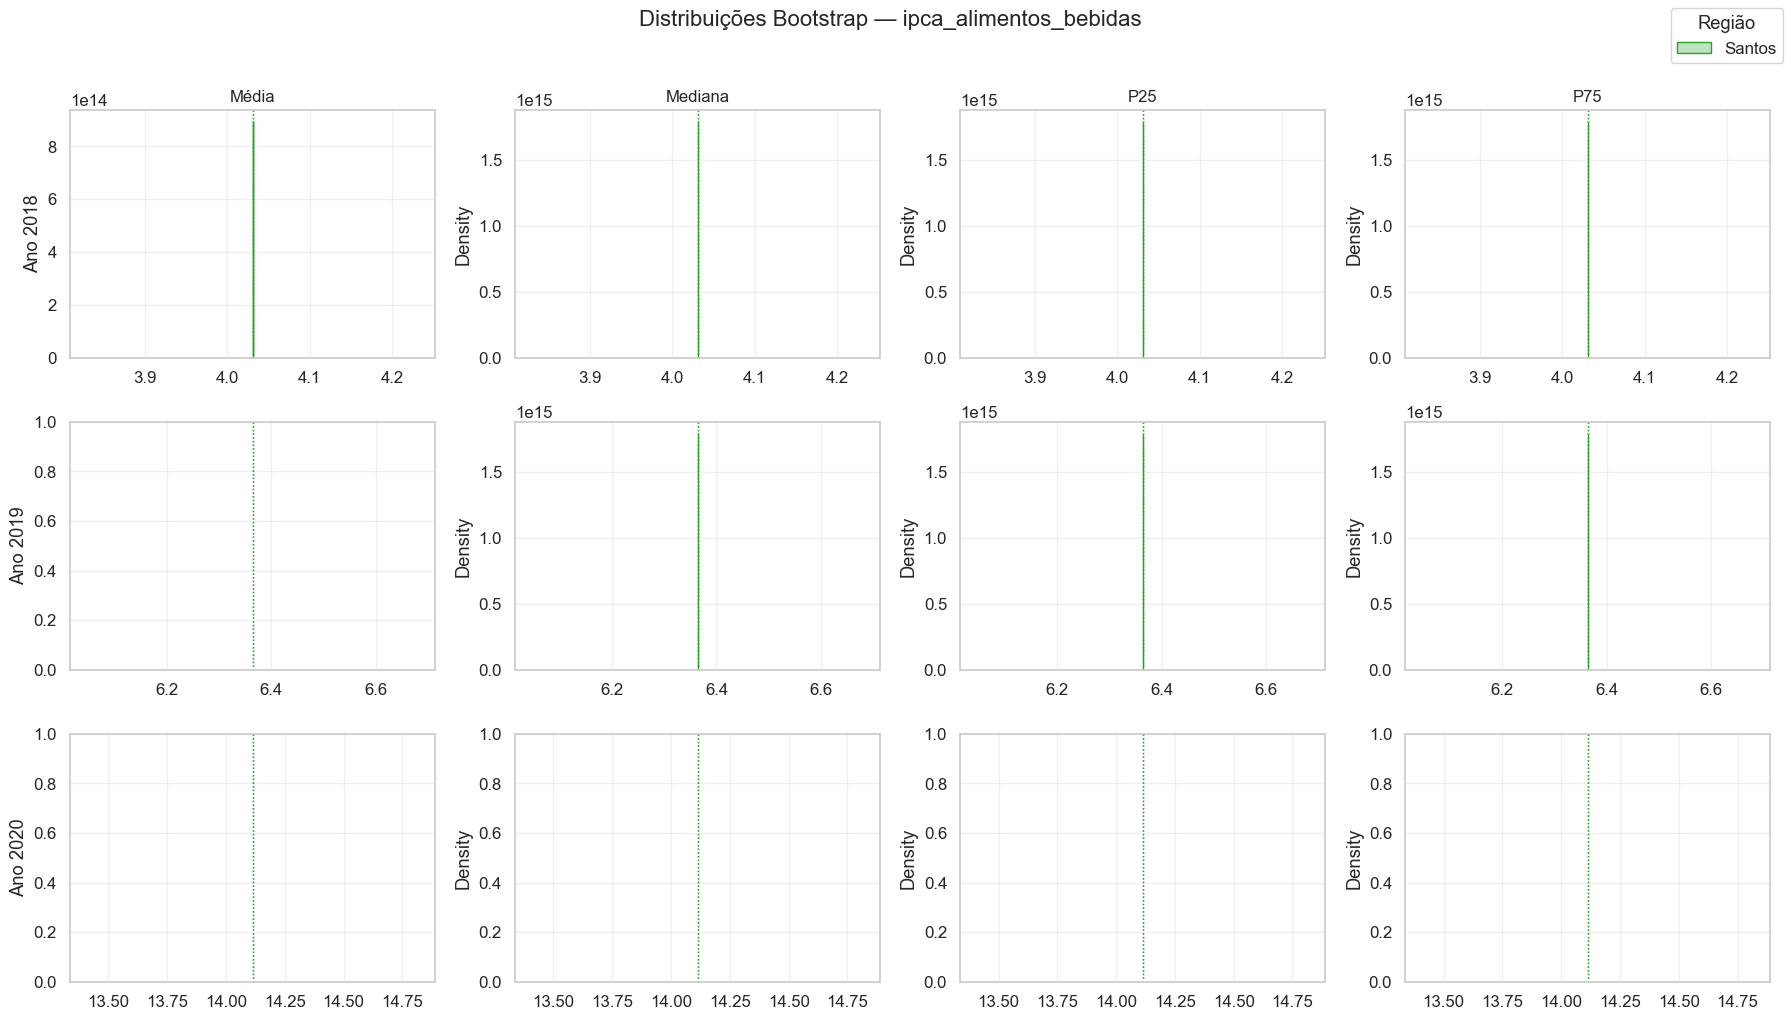

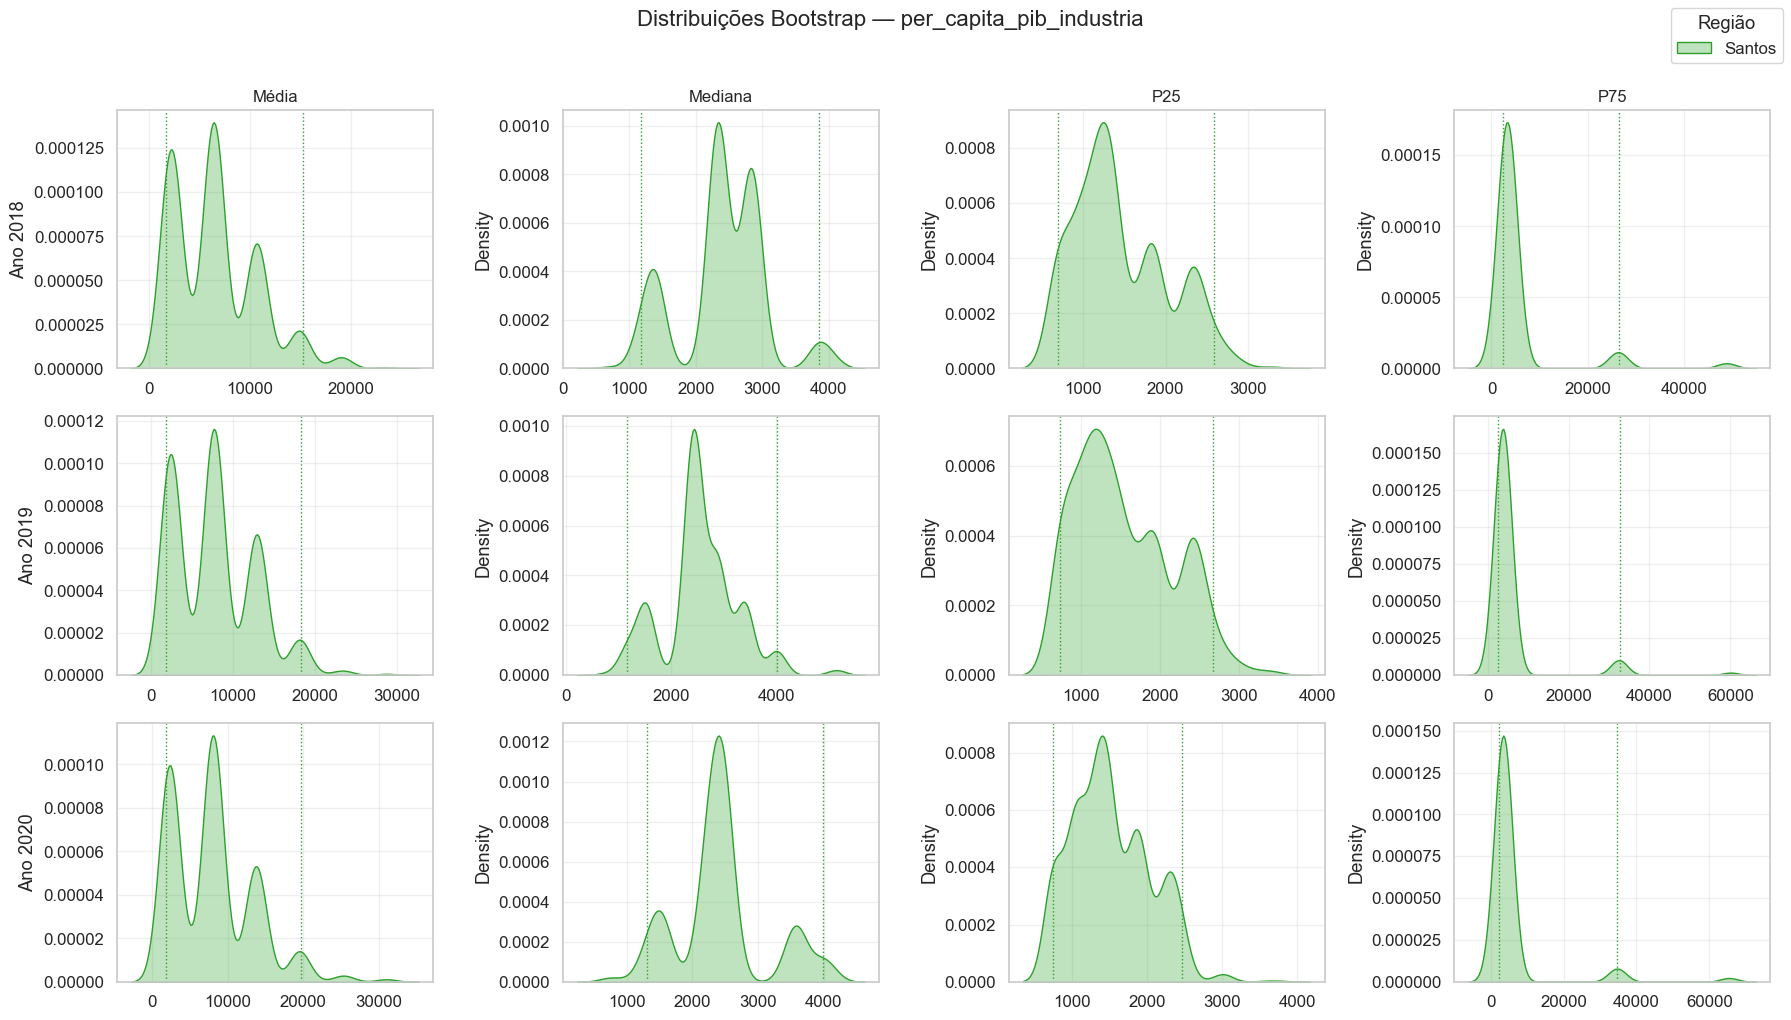

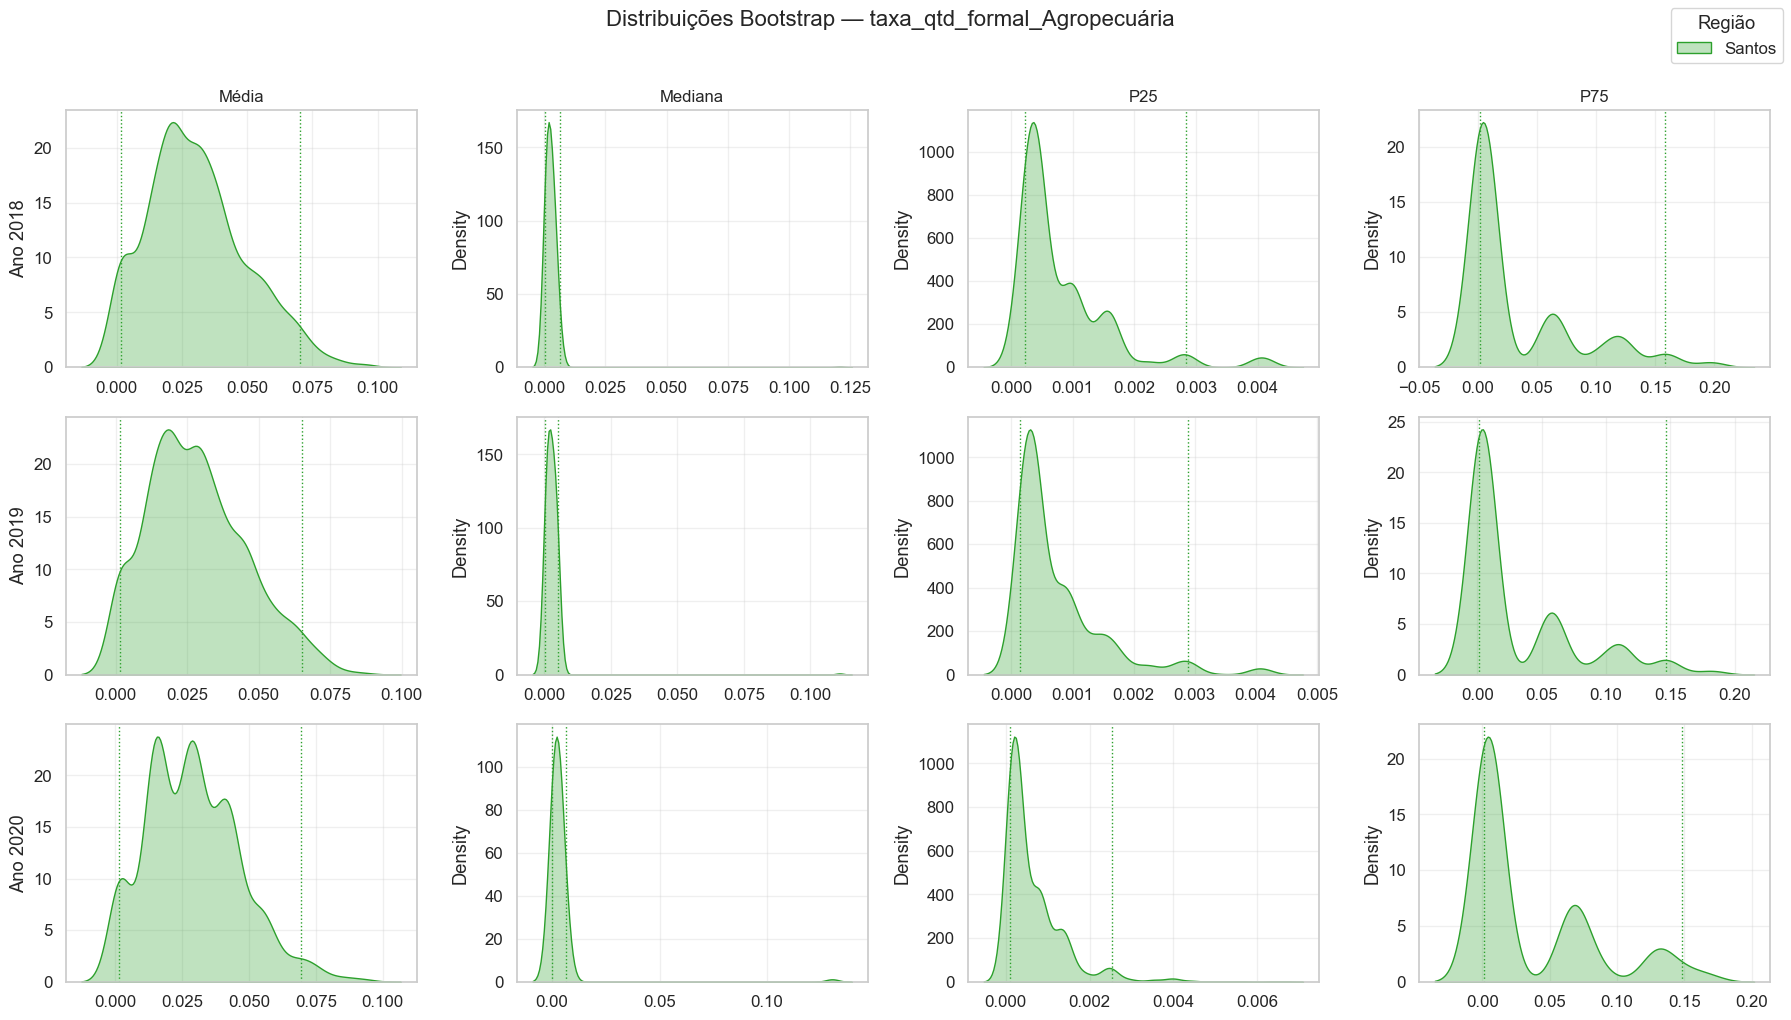

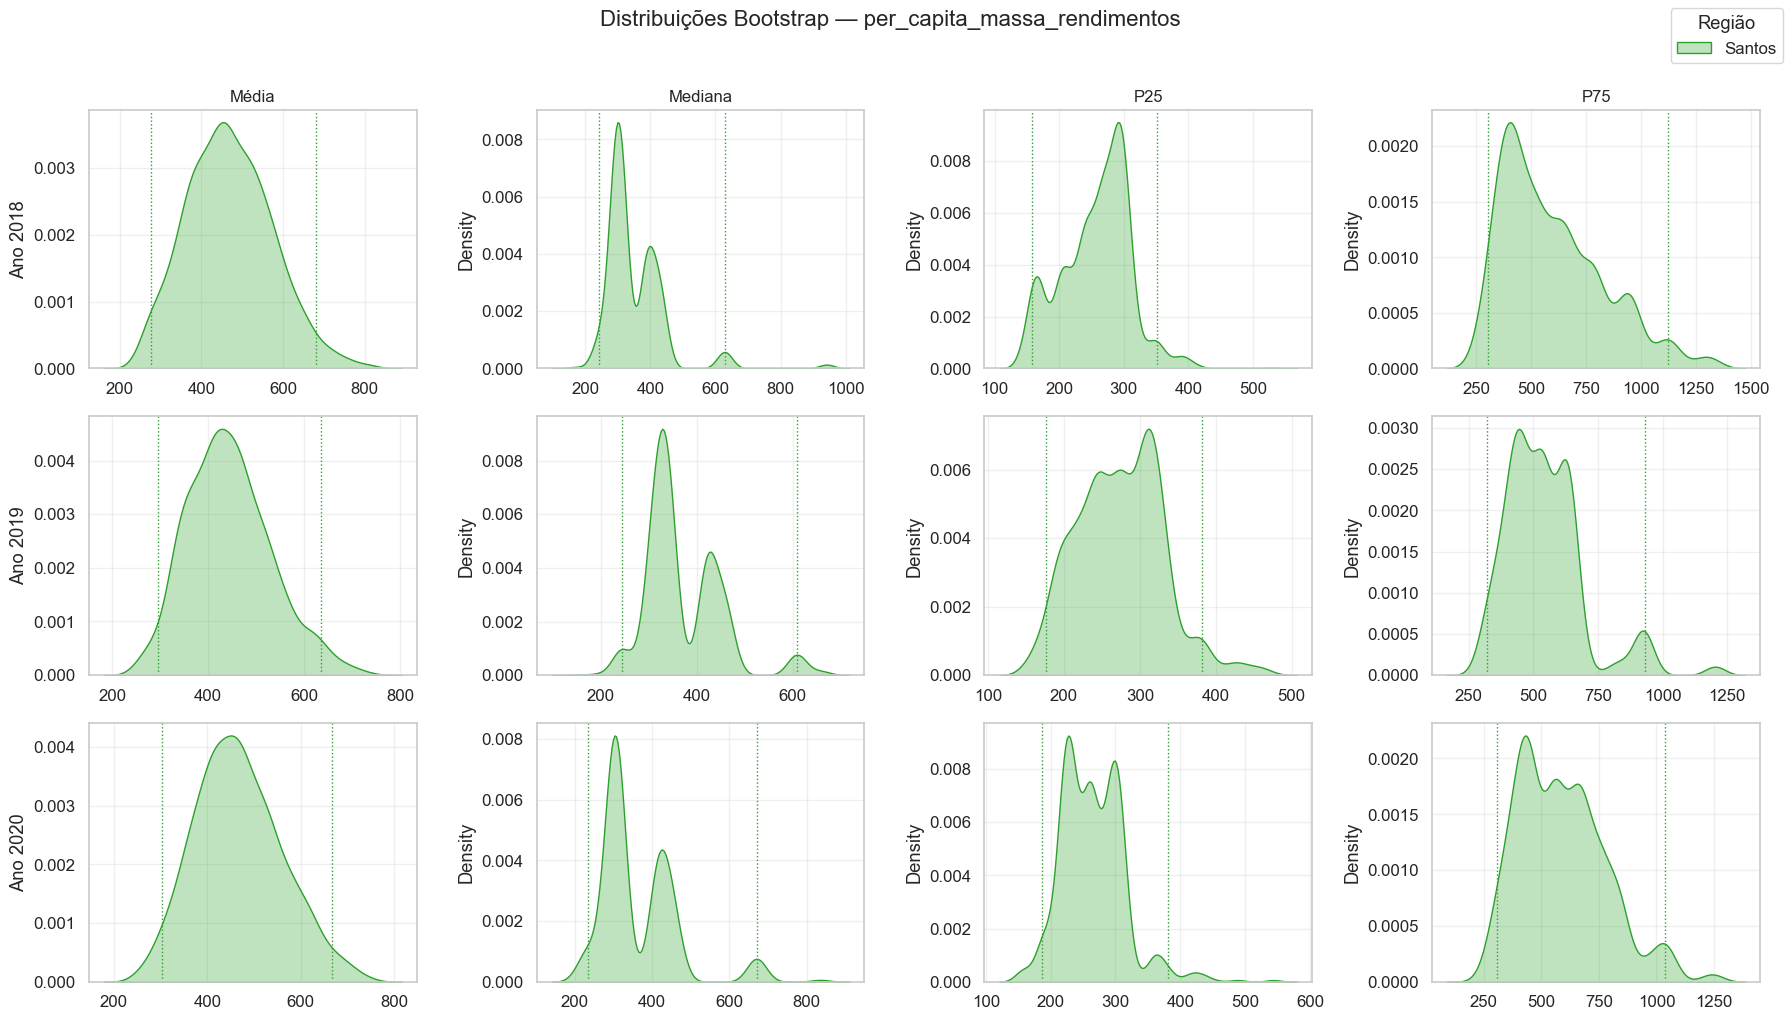

In [156]:
cols = ['ipca_alimentos_bebidas','per_capita_pib_industria', 'taxa_qtd_formal_Agropecuária', 'per_capita_massa_rendimentos']
palette = { 'Santos': '#2ca02c'}
regioes_plot = ['Santos']

anos = sorted(df_bootstrap['ano'].unique())

for col in cols:
    df_col = df_bootstrap[(df_bootstrap['coluna'] == col) &
                          (df_bootstrap['nome_regiao'].isin(regioes_plot))]

    fig, axes = plt.subplots(len(anos), len(metrics), figsize=(18, 10), sharey=False)
    fig.suptitle(f"Distribuições Bootstrap — {col}", fontsize=16, y=1.02)

    axes = np.array(axes).reshape(len(anos), len(metrics))

    for i, ano in enumerate(anos):
        df_ano = df_col[df_col['ano'] == ano]

        for j, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[i, j]

            for regiao in regioes_plot:
                df_reg = df_ano[df_ano['nome_regiao'] == regiao]

                if not df_reg.empty:
                    sns.kdeplot(
                        df_reg[metric],
                        fill=True,
                        alpha=0.3,
                        color=palette[regiao],
                        label=regiao,
                        ax=ax
                    )

                    lower_ci, upper_ci = np.percentile(df_reg[metric], [2.5, 97.5])
                    ax.axvline(lower_ci, color=palette[regiao], linestyle=':', linewidth=1)
                    ax.axvline(upper_ci, color=palette[regiao], linestyle=':', linewidth=1)

            if i == 0:
                ax.set_title(title, fontsize=12)
            if j == 0:
                ax.set_ylabel(f"Ano {ano}")

            ax.set_xlabel('')
            ax.grid(alpha=0.3)

    # legenda global
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Região', loc='upper right')

    plt.tight_layout()
    plt.show()

In [171]:
df_bootstrap.query('nome_regiao == "Santos" & coluna == "per_capita_pib_industria"').describe()

iteration          ano  cod_regiao         media      mediana  \
count  3000.000000  3000.000000      3000.0   3000.000000  3000.000000   
mean    499.500000  2019.000000    350002.0   7409.159831  2455.156344   
std     288.723115     0.816633         0.0   4894.495168   685.524490   
min       0.000000  2018.000000    350002.0   1305.466398   698.398287   
25%     249.750000  2018.000000    350002.0   2547.757061  2233.208990   
50%     499.500000  2019.000000    350002.0   7369.808270  2434.598297   
75%     749.250000  2020.000000    350002.0  10476.243082  2806.342629   
max     999.000000  2020.000000    350002.0  31244.288287  5144.602378   

               p25           p75  
count  3000.000000   3000.000000  
mean   1505.256324   5683.402467  
std     566.652046   8792.238886  
min     695.401123   1315.742292  
25%    1043.901038   2924.864238  
50%    1392.400954   3573.693311  
75%    1881.271076   4005.014322  
max    3780.690606  65417.651067

In [158]:
# tem algum IPCA q não é multimodal? desconsiderar os casos do IPCA, pq eles são fixos para tds regiões e para um ano

## Verificar os casos Multimodal

🔹 Se houver dois picos bem definidos, é multimodal de fato.
    
    - Heterogeneidade real
    
    - Segmentar a análise (ex: criar “subregiões” ou clusters espaciais distintos)

🔹 Dois picos próximos e sem padrão estrutural

    - Ruído bootstrap / amostra pequena
    
    - Usar mediana_mediana como medida robusta



## Criar o valor representativo

**dúvida: ou seria mlhr mediana_mean em vez de mediana_mediana??**

In [ ]:
def escolher_estatistica(row):
    # Se multimodal, usa mediana_mediana
    if row['n_peaks'] > 1:
        return row['mediana_mediana']
    # Se unimodal, mas assimétrica, também usar mediana
    elif abs(row['skew_media']) > 0.3:
        return row['mediana_mediana'] 
    # Caso padrão: usar média
    else:
        return row['media_mean']

summary_bootstrap_2['valor_representativo'] = summary_bootstrap_2.apply(escolher_estatistica, axis=1)


In [163]:
summary_bootstrap_2

cod_regiao nome_regiao                          coluna   ano  \
0         350001   São Paulo          ipca_alimentos_bebidas  2018   
1         350001   São Paulo          ipca_alimentos_bebidas  2019   
2         350001   São Paulo          ipca_alimentos_bebidas  2020   
3         350001   São Paulo         ipca_artigos_residencia  2018   
4         350001   São Paulo         ipca_artigos_residencia  2019   
...          ...         ...                             ...   ...   
8581      350053    Cruzeiro  taxa_qtd_formal_escolaridade_3  2019   
8582      350053    Cruzeiro  taxa_qtd_formal_escolaridade_3  2020   
8583      350053    Cruzeiro  taxa_qtd_formal_escolaridade_4  2018   
8584      350053    Cruzeiro  taxa_qtd_formal_escolaridade_4  2019   
8585      350053    Cruzeiro  taxa_qtd_formal_escolaridade_4  2020   

      media_mean  media_std  media_ci_lower  media_ci_upper  mediana_mean  \
0       4.030782   0.000000        4.030782        4.030782      4.030782   
1       6.364091   0.000000        6.364091        6.364091      6.364091   
2      14.113456   0.000000       14.113456       14.113456     14.113456   
3       3.759616   0.000000        3.759616        3.759616      3.759616   
4      -0.377431   0.000000       -0.377431       -0.377431     -0.377431   
...          ...        ...             ...             ...           ...   
8581    0.459495   0.032515        0.402823        0.525671      0.431652   
8582    0.461916   0.033169        0.404992        0.532647      0.430527   
8583    0.187122   0.013319        0.160580        0.213762      0.188244   
8584    0.192221   0.010760        0.171024        0.213555      0.194334   
8585    0.198001   0.009871        0.179369        0.217016      0.198884   

      mediana_std  mediana_mediana  p25_mediana  p75_mediana  inc_media_amp  \
0        0.000000         4.030782     4.030782     4.030782       0.000000   
1        0.000000         6.364091     6.364091     6.364091       0.000000   
2        0.000000        14.113456    14.113456    14.113456       0.000000   
3        0.000000         3.759616     3.759616     3.759616       0.000000   
4        0.000000        -0.377431    -0.377431    -0.377431       0.000000   
...           ...              ...          ...          ...            ...   
8581     0.033350         0.429942     0.420859     0.435995       0.122848   
8582     0.041551         0.411921     0.408840     0.437008       0.127655   
8583     0.024277         0.193905     0.171053     0.204626       0.053182   
8584     0.020473         0.201037     0.172370     0.214470       0.042531   
8585     0.014544         0.205298     0.187845     0.208605       0.037648   

      inc_media_cv  skew_media  kurt_media  n_peaks diagnostico_estabilidade  \
0     4.406978e-16    1.001503   -2.004012      0.0        Alta estabilidade   
1     1.395609e-16         NaN         NaN      0.0        Alta estabilidade   
2     1.258626e-16         NaN         NaN      0.0        Alta estabilidade   
3     3.543627e-16    1.001503   -2.004012      0.0        Alta estabilidade   
4    -1.470762e-16         NaN         NaN      0.0        Alta estabilidade   
...            ...         ...         ...      ...                      ...   
8581  7.072690e-02    0.350085   -0.072940      1.0                 Moderada   
8582  7.177244e-02    0.380876   -0.180515      1.0                 Moderada   
8583  7.113993e-02    0.053137    0.013942      1.0                 Moderada   
8584  5.594964e-02    0.008526   -0.151112      1.0                 Moderada   
8585  4.982637e-02    0.123452    0.150885      1.0        Alta estabilidade   

     diagnostico_assimetria      diagnostico_curtose diagnostico_multimodal  \
0     Assimétrica à direita  Platicúrtica (achatada)             Multimodal   
1                 Sem dados                Sem dados             Multimodal   
2                 Sem dados                Sem dados             Multimodal   
3     Assimétr

In [164]:
summary_bootstrap_2.query('n_peaks > 1')

cod_regiao nome_regiao                               coluna   ano  \
36        350001   São Paulo          per_capita_pib_agropecuaria  2018   
37        350001   São Paulo          per_capita_pib_agropecuaria  2019   
38        350001   São Paulo          per_capita_pib_agropecuaria  2020   
87        350001   São Paulo         taxa_qtd_formal_Agropecuária  2018   
89        350001   São Paulo         taxa_qtd_formal_Agropecuária  2020   
...          ...         ...                                  ...   ...   
8556      350053    Cruzeiro                taxa_qtd_formal_Saúde  2018   
8557      350053    Cruzeiro                taxa_qtd_formal_Saúde  2019   
8562      350053    Cruzeiro  taxa_qtd_formal_Serviços_Domésticos  2018   
8563      350053    Cruzeiro  taxa_qtd_formal_Serviços_Domésticos  2019   
8564      350053    Cruzeiro  taxa_qtd_formal_Serviços_Domésticos  2020   

      media_mean   media_std  media_ci_lower  media_ci_upper  mediana_mean  \
36    381.621052  218.958406       83.362198      910.069438     14.334417   
37    430.162309  247.042445       97.300739      988.756823     15.707104   
38    651.186034  393.246272      153.079653     1526.193037     22.668272   
87      0.020784    0.010032        0.004552        0.043014      0.001463   
89      0.017381    0.008784        0.003797        0.037059      0.001168   
...          ...         ...             ...             ...           ...   
8556    0.032033    0.021596        0.003363        0.079079      0.008086   
8557    0.027674    0.017723        0.004007        0.068733      0.007861   
8562    0.000435    0.000406        0.000000        0.001271      0.000017   
8563    0.000083    0.000061        0.000000        0.000213      0.000004   
8564    0.000076    0.000059        0.000000        0.000210      0.000004   

      mediana_std  mediana_mediana  p25_mediana  p75_mediana  inc_media_amp  \
36      10.828629        11.615565     9.096515    17.944313     826.707241   
37       8.313285        11.938433    10.255490    20.489337     891.456085   
38      18.616135        16.157441    14.023968    30.857353    1373.113383   
87       0.001261         0.000870     0.000585     0.001948       0.038461   
89       0.000964         0.000789     0.000460     0.001730       0.033262   
...           ...              ...          ...          ...            ...   
8556     0.015066         0.005338     0.002331     0.007975       0.075716   
8557     0.009081         0.008393     0.002421     0.009597       0.064727   
8562     0.000240         0.000000     0.000000     0.000000       0.001271   
8563     0.000028         0.000000     0.000000     0.000000       0.000213   
8564     0.000027         0.000000     0.000000     0.000000       0.000210   

      inc_media_cv  skew_media  kurt_media  n_peaks diagnostico_estabilidade  \
36        0.573472    0.799908    0.355105      3.0           Alta incerteza   
37        0.574013    0.873103    0.751685      2.0           Alta incerteza   
38        0.603590    0.948490    1.069293      3.0           Alta incerteza   
87        0.482452    0.550306    0.146448      2.0           Alta incerteza   
89        0.505127    0.689429    0.764679      2.0           Alta incerteza   
...            ...         ...         ...      ...                      ...   
8556      0.673839    0.835753    0.689195      3.0           Alta incerteza   
8557      0.640084    0.825660    0.494175      2.0           Alta incerteza   
8562      0.931256    0.989011    1.284018      3.0           Alta incerteza   
8563      0.741879    0.688736    0.267426      3.0           Alta incerteza   
8564      0.775358    0.901075    0.810758      3.0           Alta incerteza   

     diagnostico_assimetria   diagnostico_curtose diagnostico_multimodal  \
36    Assimétrica à direita  Mesocúrtica (normal)             Multimodal   
37    Assimétrica à direita  Mesocúrtica (normal)                Bimodal   
38    Assimétrica à direita  M

In [166]:
df_bootstrap

iteration   ano  cod_regiao nome_regiao  \
0                0  2018      350001   São Paulo   
1                0  2018      350001   São Paulo   
2                0  2018      350001   São Paulo   
3                0  2018      350001   São Paulo   
4                0  2018      350001   São Paulo   
...            ...   ...         ...         ...   
8585995        999  2020      350053    Cruzeiro   
8585996        999  2020      350053    Cruzeiro   
8585997        999  2020      350053    Cruzeiro   
8585998        999  2020      350053    Cruzeiro   
8585999        999  2020      350053    Cruzeiro   

                                             coluna        media      mediana  \
0                                  perc_Pop_65_mais     0.080956     0.079262   
1                      taxa_qtd_formal_Agropecuária     0.007194     0.002423   
2        taxa_qtd_formal_Indústria_de_Transformação     0.224197     0.218152   
3                            ipca_alimentos_bebidas     4.030782     4.030782   
4                             taxa_qtd_formal_Saúde     0.033600     0.031553   
...                                             ...          ...          ...   
8585995                              ipca_habitacao     5.274873     5.274873   
8585996                               ipca_educacao     1.134802     1.134802   
8585997       taxa_qtd_formal_Administração_Pública     0.302878     0.203421   
8585998                ipca_saude_cuidados_pessoais     1.501329     1.501329   
8585999                    per_capita_pib_industria  4666.979268  2996.530068   

                p25          p75  
0          0.069103     0.089276  
1          0.000203     0.007385  
2          0.140644     0.298614  
3          4.030782     4.030782  
4          0.016377     0.043427  
...             ...          ...  
8585995    5.274873     5.274873  
8585996    1.134802     1.134802  
8585997    0.127920     0.472492  
8585998    1.501329     1.501329  
8585999  567.040541  8938.142305  

[8586000 rows x 9 columns]

In [ ]:
#df_bootstrap.to_csv('bases_analises/df_bootstrap_regioes.csv', index=False)

In [ ]:
#summary.to_excel('bases_analises/summary_bootstrap_regioes.xlsx', index=False)

In [167]:
summary_bootstrap_2.to_excel('bases_analises/summary_bootstrap_regioes.xlsx', index=False)

In [ ]:
# ver as caudas de p25 e p75 para ver a dispersão nas extremidades
# como esses dados são distribuidos -> coeficiente de correlação espaciais entre regiões
# mapa de calor por variável e dps de correlação dois a dois - multinformation (eu acho q é correlação multipla). tentar ver essas coisas espaciais
# utilizar o pySAL para fazer essas análises espaciais

